# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Логика выполнения работы

Задача сформулирована достаточно расплывчато, поэтому сузим ее для себя.

Во-первых, оценим, нет ли в выборке совершенно неадекватных строк, которые предсказывать не надо. Если есть - удалим их.

Во-вторых, у нас нет отдельной тестовой выборки. Эту проблему решим, смоделировав соревнование на каггле:
- разделим имеющиеся данные на обучающую и тестовую выборки
- обучающая выборка доступна всегда целиком. Мы можем делать с ней все, что угодно: удалять, размножать, зашумлять и т.д.
- предикторы тестовой выборки доступны всегда целиком. Мы можем их модифицировать, но не можем удалять строки - количество предсказаний должно быть равно количеству строк тестовой выборки
- целевой признак тестовой выборки "недоступен", но мы можем несколько раз в день послать решение на проверку и получить истинную метрику на тестовой выборке

Потом будем обучать модели и измерять для каждой:
- метрику на тесте
- время обучения
- время предсказания (вся тестовая выборка сразу)
- время подбора гиперпараметров

## Техническая часть

Для полноценного запуска ставится is_final = True, а для отработки - false.

In [1]:
is_final = True
timeout = 30 * 60 # is_final = true
timeout_small = 20 # is_final = false
feature_importance_n_repeats = 40 # is_final = true

In [2]:
import warnings
warnings.filterwarnings('ignore')
#import sys
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import model_selection, tree, linear_model, metrics, ensemble, preprocessing, neighbors, compose, naive_bayes, svm, set_config, impute, manifold, feature_selection, inspection, pipeline, decomposition
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin, clone
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
import xgboost as xgb
import phik
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
import category_encoders
import optuna
import catboost as cat
from catboost import Pool, cv
#optuna.logging.set_verbosity(optuna.logging.INFO)
optuna.logging.set_verbosity(optuna.logging.WARNING)
import time
import copy
import gc
import requests
from tqdm import tqdm
import urllib.request
import zipfile, io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler, Sampler, SequentialSampler
import regex as re
from typing import Union, Any

project_start = time.time()

Поставим еще патч от интела для ускорения работы sklearn, пусть даже в этой работе бонус от него будет невелик.

In [3]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
%matplotlib inline
set_config(display="diagram")
xgb.set_config(verbosity=0)
sns.set()
sns.set(rc = {'figure.figsize':(12,8)})
sns.set_style("whitegrid")
sns.set_palette('pastel')
plt.rcParams["figure.figsize"] = (12, 8)

In [5]:
random_state = 2077
max_iter = 10000
np.random.seed(seed=random_state)
torch.manual_seed(random_state)

## Подготовка данных

### Загрузка данных

In [6]:
file_path = 'H:/Google_d/2021_ШАД/Yandex - project 11/'

def load_dataframe(filename, file_path, showinfo=True, showdescribe=False, showcolumns=True, d=dict(index_col=0)):
    try:
        df = pd.read_csv('/datasets/' + filename, sep=',', **d)  # Серверный путь
        print('Загружено с сервера')
    except:
        try:
            df = pd.read_csv(file_path + filename, sep=',', **d)  # Локальный путь
            print('Загружено с локального диска')
        except:
            try:
                df = pd.read_csv('/content/' + filename, sep=',', **d)  # Путь гугл-диска
                print('Загружено с гугл-диска')
            except: print('Файл не найден')
    df.columns = [i.lower().strip().replace(' ','') for i in df.columns]
    print('Количество строк', len(df))
    print('Количество столбцов', len(df.columns))
    print('Количество дубликатов', df.duplicated().sum())
    print('Количество пропусков всего', df.isna().sum(axis=1).sum(axis=0))
    a = df.isna().sum()
    print('Количество столбцов с пропусками', len(a[a>0]))
    print('Количество всех типов данных:\n', df.dtypes.value_counts().to_string())

    df.columns = df.columns.str.replace('primary', 'prim')
    df.columns = df.columns.str.replace('secondary', 'secn')
    df.columns = df.columns.str.replace('_cleaner', '_cln')
    df.columns = df.columns.str.replace('calculation', 'calc')

    if showinfo:
        display(df.info())
    if showdescribe:
        display(df.describe(include='all').T)
    if showcolumns:
        print(df.columns.tolist())
    return df

In [7]:
df = load_dataframe(filename ='autos.csv', file_path=file_path, d={})

Загружено с локального диска
Количество строк 354369
Количество столбцов 16
Количество дубликатов 4
Количество пропусков всего 181077
Количество столбцов с пропусками 5
Количество всех типов данных:
 object    9
int64     7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        316879 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   kilometer          354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           321474 non-null  object
 10  brand              354369 non-null  object
 11  notrepaired        283215 non-null  

None

['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox', 'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand', 'notrepaired', 'datecreated', 'numberofpictures', 'postalcode', 'lastseen']


Данные загрузились, столбцы адекватные. Всего у нас более 350к строк - неплохо.

In [8]:
for c in ['datecrawled', 'lastseen', 'datecreated']:
    df[c] = pd.to_datetime(df[c])

for c in ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand']:
    df[c] = df[c].str.lower()

Видим, что датасет приличного размера. По идее его можно сжать в памяти без потерь. Используем функцию, найденную в интернетах.

In [9]:
def reduce_mem_usage(df, int_cast=True, obj_to_category=False, subset=None):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.
    :param df: dataframe to reduce (pd.DataFrame)
    :param int_cast: indicate if columns should be tried to be casted to int (bool)
    :param obj_to_category: convert non-datetime related objects to category dtype (bool)
    :param subset: subset of columns to analyse (list)
    :return: dataset with the column dtypes adjusted (pd.DataFrame)
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2;
    gc.collect()
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    cols = subset if subset is not None else df.columns.tolist()

    for col in tqdm(cols):
        col_type = df[col].dtype

        if col_type != object and col_type.name != 'category' and 'datetime' not in col_type.name:
            c_min = df[col].min()
            c_max = df[col].max()

            # test if column can be converted to an integer
            treat_as_int = str(col_type)[:3] == 'int'
            if int_cast and not treat_as_int:
                treat_as_int = check_if_integer(df[col])

            if treat_as_int:
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                    df[col] = df[col].astype(np.uint64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif 'datetime' not in col_type.name and obj_to_category:
            df[col] = df[col].astype('category')
    gc.collect()
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.3f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [10]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 43.26 MB


100%|██████████| 16/16 [00:00<00:00, 642.14it/s]

Memory usage after optimization is: 29.740 MB
Decreased by 31.2%


In [11]:
df.describe().round(2).T

count       mean       std     min       25%       50%  \
price              354369.0    4416.66   4514.16     0.0    1050.0    2700.0   
registrationyear   354369.0    2004.23     90.23  1000.0    1999.0    2003.0   
power              354369.0     110.09    189.85     0.0      69.0     105.0   
kilometer          354369.0  128211.17  37905.34  5000.0  125000.0  150000.0   
registrationmonth  354369.0       5.71      3.73     0.0       3.0       6.0   
numberofpictures   354369.0       0.00      0.00     0.0       0.0       0.0   
postalcode         354369.0   50508.69  25783.10  1067.0   30165.0   49413.0   

                        75%       max  
price                6400.0   20000.0  
registrationyear     2008.0    9999.0  
power                 143.0   20000.0  
kilometer          150000.0  150000.0  
registrationmonth       9.0      12.0  
numberofpictures        0.0       0.0  
postalcode          71083.0   99998.0

Видим, что numberofpictures везде ноль без вариантов. Удаляем.

Кроме того, видим, что все машины БУ - минимальный километраж 5000. Есть искусственное ограничение километража сверху - 150000, это ограничение ухудшит качество модели.

Год регистрации - в целом адекватно, но есть странные минимальные и максимальные значения.

Месяц регистрации - вероятно, бесполезен.

Почтовый индекс - вероятно, бесполезен. Но кто знает?

In [12]:
df = df.drop(columns=['numberofpictures'])

In [13]:
df.describe(include='object').round(2).T

count unique         top    freq
vehicletype  316879      8       sedan   91457
gearbox      334536      2      manual  268251
model        334664    250        golf   29232
fueltype     321474      7      petrol  216352
brand        354369     40  volkswagen   77013
notrepaired  283215      2          no  247161

Очень много моделей, много брендов. Это будет проблемой.

In [14]:
df.describe(include='datetime64', datetime_is_numeric=True).round(2)

datecrawled                    datecreated  \
count                         354369                         354369   
mean   2016-03-21 12:58:10.450648320  2016-03-20 19:12:07.753274112   
min              2016-03-05 14:06:22            2014-03-10 00:00:00   
25%              2016-03-13 11:52:33            2016-03-13 00:00:00   
50%              2016-03-21 17:50:55            2016-03-21 00:00:00   
75%              2016-03-29 14:37:20            2016-03-29 00:00:00   
max              2016-04-07 14:36:58            2016-04-07 00:00:00   

                            lastseen  
count                         354369  
mean   2016-03-29 23:51:00.667456768  
min              2016-03-05 14:15:08  
25%              2016-03-23 02:50:03  
50%              2016-04-03 15:15:51  
75%              2016-04-06 10:15:19  
max              2016-04-07 14:58:51

Вероятно, эти признаки бесполезны. Но пока не будем удалять.

### Целевой признак

До того, как делать выборки, посмотрим на целевой признак внимательно.

Скажем прямо: у нас метрика RMSE, очень чувствительная к выбросам. Поэтому наличие таких выбросов в (кросс-)валидационных и в тестовой выборках будет стабильно снижать результирующую метрику модели. Подбор гиперпараметров при этом будет проводиться не для улучшения реального качества модели, а для подгона ее под выбросы.

Поэтому нам необходимо решить проблему выбросов сразу и жестко.

Посмотрим на распределение целевого признака.

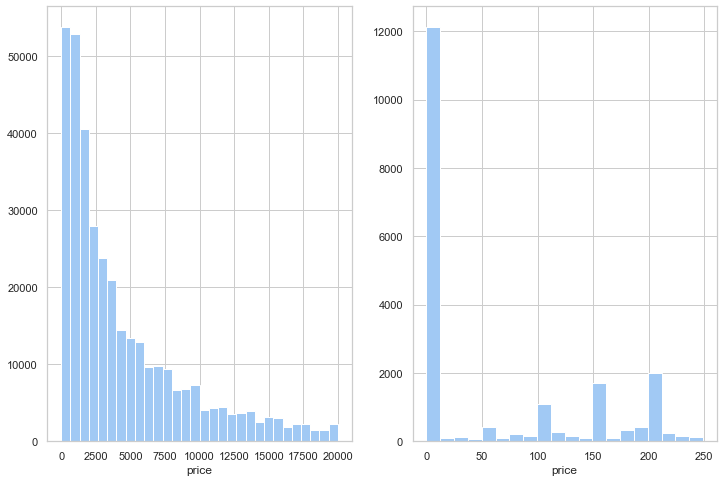

In [15]:
p = df['price']
plt.subplot(1,2,1)
p.hist(bins=30)
plt.xlabel('price')
plt.subplot(1,2,2)
p[p < 250].hist(bins=20)
plt.xlabel('price');

Удобно, что цена заканчивается на 20000, то есть тут нет совсем каких-то элитных уникальных автомобилей, цену которых невозможно предсказать той же моделью, что и для ширпотреба.

Отметим, что есть максимумы на 0, 50, 100 и т.д. Посмотрим на сверхмалые цены. Будем считать, что 250 - адекватная цена для полностью разваливающегося корыта.

Например, вот тут цены начинаются со 100, а адекватные - с 200-250: [европейский сайт по продаже авто](https://www.ooyyo.com/germany/used-cars-for-sale/c=CDA31D7114D3854F111BFE6FB6A03C53CCA20A700ED3A760/)


In [16]:
df[p < 10].head(10)

datecrawled  price vehicletype  registrationyear gearbox  power  \
7   2016-03-21 18:54:38      0       sedan              1980  manual     50   
40  2016-03-26 22:06:17      0         NaN              1990     NaN      0   
59  2016-03-29 15:48:15      1         suv              1994  manual    286   
89  2016-03-28 09:37:01      1       sedan              1995  manual    113   
111 2016-03-19 18:40:12      0         NaN              2017  manual      0   
115 2016-03-20 18:53:27      0       small              1999     NaN      0   
152 2016-03-11 18:55:53      0         bus              2004  manual    101   
154 2016-03-22 16:37:59      0         NaN              2006     NaN      0   
231 2016-03-16 22:06:24      0       wagon              2001  manual    115   
268 2016-03-12 07:26:49      1       sedan              1990  manual     90   

        model  kilometer  registrationmonth  fueltype           brand  \
7       other      40000                  7    petrol      volkswagen   
40      corsa     150000                  1    petrol            opel   
59        NaN     150000                 11       NaN  sonstige_autos   
89   e_klasse     150000                  4  gasoline   mercedes_benz   
111      golf       5000                 12    petrol      volkswagen   
115       NaN       5000                  0    petrol      volkswagen   
152    meriva     150000                 10       lpg            opel   
154     other       5000                  0       NaN            fiat   
231    mondeo     150000                  0       NaN            ford   
268        80      70000                  6    petrol            audi   

    notrepaired datecreated  postalcode            lastseen  
7            no  2016-03-21       19348 2016-03-25 16:47:58  
40          NaN  2016-03-26       56412 2016-03-27 17:43:34  
59          NaN  2016-03-29       53721 2016-04-06 01:44:38  
89           no  2016-03-28       40589 2016-04-06 12:15:54  
111         NaN  2016-03-19       21698 2016-04-01 08:47:05  
115         NaN  2016-03-20       37520 2016-04-07 02:45:22  
152         yes  2016-03-11       27432 2016-03-12 23:47:10  
154         NaN  2016-03-22       44867 2016-04-06 06:17:56  
231         NaN  2016-03-16       57627 2016-03-26 11:17:50  
268          no  2016-03-11       55122 2016-03-26 23:15:49

Видим, что это вполне... адекватные автомобили, некоторые даже новые. Делаем вывод, что эти данные заполнены некорректно, и на них нельзя обучать модель. Кроме того, на них нельзя и проверять модель!

Вряд ли человек, пытающийся получить оценку автомобиля, хочет узнать, что его гольф 2017 года стоит 0 евро. Или даже 100.

Поэтому просто удалим их.

In [17]:
df = df[df['price'] >= 250]
df = df.reset_index(drop=True)

Больше ничего удалять сходу не будем.

### Предобработка

В целом было бы правильно реализовать большую часть предобработки внутри самих моделей через пайплайны. Но есть отдельные аспекты, которые стоит сделать заранее.

Например, из модели машины однозначно следует ее производитель.

Отдельно отметим, что допустимость использования предикторов (не целевого признака! Его никогда нельзя) из тестовой выборки при подготовке данных - это спорный вопрос. Но в формате каггла - можно.


Сначала посмотрим на самые редкие модели.

In [18]:
tmp = df['model'].value_counts().sort_values().head(9)
tmp

serie_1               1
range_rover_evoque    2
serie_3               3
rangerover            4
elefantino            6
samara                8
serie_2               8
i3                    8
kalina                9
Name: model, dtype: int64

По ним предсказкания будут, вероятно, плохими, поэтому стоит вкинуть их в other.

In [19]:
tmp = df['model'].value_counts().sort_values().head(5)
df.loc[df['model'].isin(tmp.index), 'model'] = 'other'

Напишем функцию для заполнения на основе группировки по какой-либо колонке (например, модель). В случае other заполнять не будем.

In [20]:
def fill_by_group_transform(col_to_fill, col_to_group, only_one=False):
    global df
    print(f'Количество пропусков в столбце {col_to_fill} до обработки', df[col_to_fill].isna().sum())
    tmp = df[df[col_to_group] != 'other'].groupby(col_to_group)[col_to_fill].transform(
        lambda x: x.mode()[0] if not only_one else (
            x.mode()[0] if len(x.mode()==1) and len(x)>3 else np.nan
        )
    )
    df[col_to_fill] = df[col_to_fill].fillna(tmp)
    df[col_to_fill].isna().sum()
    print(f'Количество пропусков в столбце {col_to_fill} после обработки', df[col_to_fill].isna().sum())

fill_by_group_transform(col_to_fill='brand', col_to_group='model')

Количество пропусков в столбце brand до обработки 0
Количество пропусков в столбце brand после обработки 0


Заполним пропуски в типах авто на основе самого популярного для каждой модели. Не факт, что это лучшая стратегия, но хоть что-то. Остаток скинем в other. Тоже неоднозначное решение, честно скажем. Но какое качество данных, такое и качество результата - магии не бывает.

In [21]:
df['model'] = df['model'].fillna('other')
fill_by_group_transform(col_to_fill='vehicletype', col_to_group='model')
df['vehicletype'] = df['vehicletype'].fillna('other')

Количество пропусков в столбце vehicletype до обработки 30731
Количество пропусков в столбце vehicletype после обработки 6408


Теперь будем использовать параметр only_one=True, то есть будем заполнять пропуски только в том случае, если у всех записей по модели фича одинаковая. Например, если у всех гольфов коробки только механические (и пропуски), то пропуски заполняем механической коробкой. А если хотя бы у одного автомат, то не заполняем.

In [22]:
fill_by_group_transform(col_to_fill='gearbox', col_to_group='model', only_one=True)

Количество пропусков в столбце gearbox до обработки 15208
Количество пропусков в столбце gearbox после обработки 3605


In [23]:
fill_by_group_transform(col_to_fill='fueltype', col_to_group='model', only_one=True)

Количество пропусков в столбце fueltype до обработки 26626
Количество пропусков в столбце fueltype после обработки 6786


Дальше сложнее. Вообще-то у каждой модели есть собственные годы выпуска, а также ряд двигателей с известными мощностями. Кроме того, у многих моделей (особенно старых) есть только один тип коробки передач.

Из имеющихся данных вытащить эти сведения, к сожалению, невозможно - слишком много выбросов. Поэтому есть мысль - пройтись по самым популярным моделям и вручную найти и подставить основные параметры. Для начала посмотрим, как будет зависеть наше "покрытие" датасета от количества обработанных моделей.

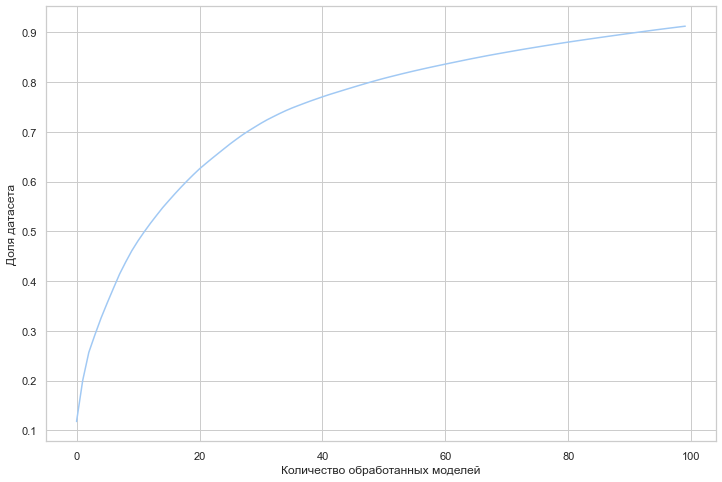

In [24]:
a = df['model'].value_counts()
ind = [0]
l = len(df)
part = [a.iloc[0]/l]

for i in range(100):
    if i == 0: continue
    ind.append(i)
    part.append(part[i-1] + a.iloc[i]/l)
ax = sns.lineplot(x=ind, y=part)
ax.set(xlabel='Количество обработанных моделей', ylabel='Доля датасета');

То есть, вручную обработав менее 15 моделей, мы вычистим половину датасета!

Но искать все параметры даже для 15 моделей - это трудоемкий процесс, причем самые популярные авто - это авто с долгой историей и с множеством различных модификаций. Поэтому в рамках данного проекта не будем этим заниматься.

Больше ничего уверенно сказать нельзя, поэтому остальную обработку оставим на потом.

## Создание обучающей и тестовой выборок

Модуль scikit-learn-intelex немного нарушает работу train_test_split, поэтому тут небольшой костыль.

Кроме того, мы хотим, чтобы тестовая выборка была хоть сколько репрезентативной, поэтому сделаем стратификацию по бренду.

Сразу создадим переменную number_test_lines_before, по которой потом будем проверять, что не потеряли строки тестовой выборки.

In [25]:
a, b = model_selection.train_test_split(
            df.index,
            test_size = 0.25,
            random_state=random_state,
            shuffle=True,
            stratify=df['brand'].fillna('nan')
            )

df['sample'] = 'train'
df.loc[b, 'sample'] = 'test'
number_test_lines_before = df['sample'].value_counts()[-1]
df['sample'].value_counts()

train    250783
test      83595
Name: sample, dtype: int64

## EDA

Уже видно, что в данных много проблемных мест. Поэтому придется пройти по столбцам и разобрать, что же там происходит.

Сделаем функцию для гистограмм + боксплотов и проверим ее.

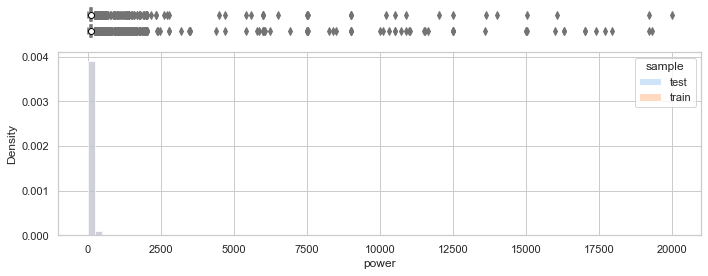

Количество пропусков в выборках


sample
test     0
train    0
Name: power, dtype: int64

In [26]:
def feature_analyze(data, col_name, bins=80, figsize=(10, 4), box=True, logscale=False, text_out=True):
    if box:
        f, (ax_box, ax_hist) = plt.subplots(2, figsize=figsize, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    else:
        f, (ax_hist) = plt.subplots(1, figsize=figsize)
    g = sns.histplot(data=data, x=col_name, bins=bins, ax=ax_hist, hue='sample',
                     stat='density', common_norm=False)
    if 'ns' in data[col_name].dtype.str:
        plt.xticks(rotation=45)
    if logscale:
        g.set_yscale('log')
    if box:
        sns.boxplot(data=data, x=col_name, y='sample', ax=ax_box, showmeans=True, meanprops={
                "marker":"o",
                "markerfacecolor":"white",
                "markeredgecolor":"black",
                "markersize":"6"})
        ax_box.set_axis_off()
    ax_hist.set(xlabel=col_name)
    f.tight_layout()
    plt.show()
    if text_out:
        print('Количество пропусков в выборках')
        display(data.set_index('sample').isna().groupby(level=0)[col_name].sum())

feature_analyze(df, 'power', box=True)

Функция работает, но есть нюанс... с конкретными значениями будем разбираться позже.

### Даты

Сначала пробежимся по датам

### Дата создания объявления

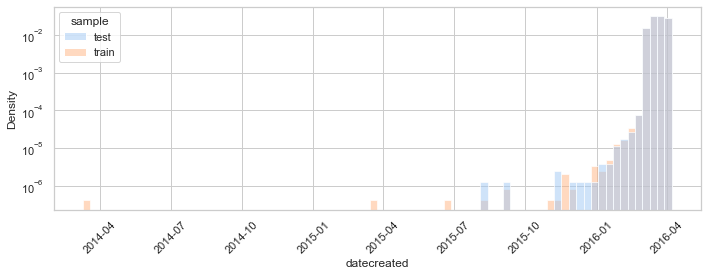

Количество пропусков в выборках


sample
test     0
train    0
Name: datecreated, dtype: int64

In [27]:
feature_analyze(df, 'datecreated', box=False, logscale=True)

Есть данные об очень старых объявлениях. Их мало, да и временной диапазон все равно не очень большой - всего два года. Для страны со стабильной экономикой за это время цены не должны были сильно поменяться.

Для очистки совести посмотрим на эти значения.

In [28]:
dat_lim = pd.to_datetime('2015-10')
df[(df['datecreated'] < dat_lim)]

datecrawled  price  vehicletype  registrationyear gearbox  \
3764   2016-03-23 14:42:46   6000          bus              1995    auto   
57739  2016-03-16 11:48:06   8999        sedan              2005  manual   
71348  2016-03-14 08:43:53    600        small              2005  manual   
81730  2016-04-02 19:47:40  14250  convertible              2005  manual   
165188 2016-03-08 17:57:45   5200  convertible              2006  manual   
208421 2016-03-15 01:56:49    600        small              2005  manual   
321388 2016-03-05 21:51:02   9500        small              2013  manual   
322955 2016-03-05 21:44:26  10400          bus              1993  manual   

        power    model  kilometer  registrationmonth  fueltype          brand  \
3764      200    other     150000                  0    petrol      chevrolet   
57739       0      147     125000                  0    petrol     alfa_romeo   
71348      54     polo     150000                  1    petrol     volkswagen   
81730     163      slk     150000                  6    petrol  mercedes_benz   
165188    109  2_reihe      80000                 11    petrol        peugeot   
208421     54     polo     150000                  1    petrol     volkswagen   
321388     90    corsa      50000                  4  gasoline           opel   
322955      0   ducato      30000                  1  gasoline           fiat   

       notrepaired datecreated  postalcode            lastseen sample  
3764            no  2015-03-20       24558 2016-04-07 03:45:01  train  
57739          NaN  2014-03-10       79669 2016-04-07 04:46:24  train  
71348          yes  2015-09-04       72669 2016-03-15 14:16:58  train  
81730           no  2015-08-07       76228 2016-04-07 09:15:23   test  
165188          no  2015-08-10       26382 2016-04-05 20:46:54  train  
208421         yes  2015-09-04       72669 2016-03-15 15:49:29   test  
321388          no  2015-09-09       98739 2016-04-05 17:46:04  train  
322955         NaN  2015-06-18       76275 2016-04-05 17:46:09  train

Вроде обычные машины... не будем их трогать.

### Дата кроулинга

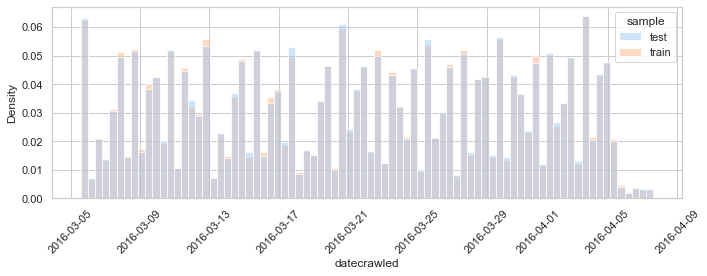

Количество пропусков в выборках


sample
test     0
train    0
Name: datecrawled, dtype: int64

In [29]:
feature_analyze(df, 'datecrawled', box=False)

Видимо, это данные о том, в какой момент наш кроулер нашел объявление. Вероятно, это совершенно бесполезная для предсказаний информация.

Но может оказаться, что эта величина коррелирует с какой-нибудь полезной величиной - например, он сначала нашел все легковушки, потом все автобусы и т.д.

### Дата последней активности

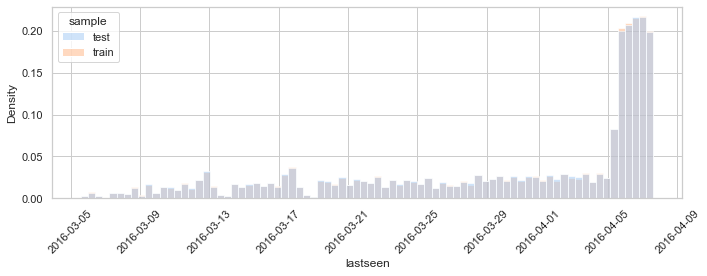

Количество пропусков в выборках


sample
test     0
train    0
Name: lastseen, dtype: int64

Доля свежих объявлений 0.4683262654839732


In [30]:
feature_analyze(df, 'lastseen', box=False)
print('Доля свежих объявлений', len(df[df['lastseen'] > pd.to_datetime('2016-04-05')]) / len(df))

А вот это интересный график - видим, что около половины всех записей лежит до 2016-04-05, а половина - после. Я бы предположил, что записи до этой даты - закрытые объявления, а после - открытые.

Все записи лежат в узком диапазоне - март-апрель 2016 г, то есть все цены там актуальные.

Возможно, "старые" записи означают более низкие цены, поэтому машину купили и объявление сняли? А "новые" - это, возможно, люди, которые не торопятся и ждут покупателя на свою высокую цену.

### Количественные признаки

### Год регистрации

Вероятно, совпадает с годом выпуска авто.

Сразу очистим откровенные выбросы (заметим, что мы одинаково обращаемся с тестовой и обучающей выборкой, чтобы на кросс-валидации получать адекватные результаты).

In [31]:
df.loc[df['registrationyear'] < 1900, 'registrationyear'] = np.nan
df.loc[df['registrationyear'] >= 2020, 'registrationyear'] = np.nan

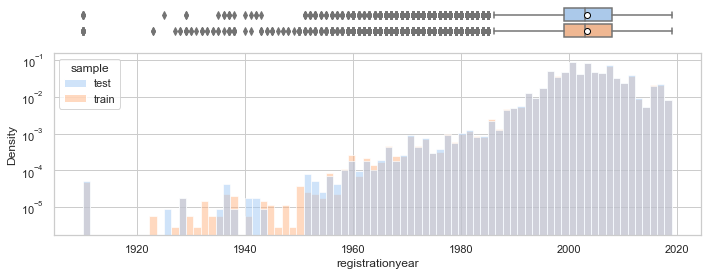

Количество пропусков в выборках


sample
test     19
train    81
Name: registrationyear, dtype: int64

In [32]:
feature_analyze(df, 'registrationyear', logscale=True)

Видим, что где-то с 1960-х идет довольно много машин, а вот до 1950-х ситуация очень странная. Посмотрим, что там за машины.

Кроме того, есть машины из будущего - вплоть до 2019 года (а на дворе 2016).

In [33]:
df.sort_values('registrationyear').head(10)

datecrawled  price vehicletype  registrationyear gearbox  \
73962  2016-04-04 20:39:52    250       other            1910.0     NaN   
257994 2016-03-09 13:50:32   2500       other            1910.0     NaN   
211182 2016-03-20 07:37:16   1500         bus            1910.0  manual   
53853  2016-03-30 07:36:23   1000       other            1910.0     NaN   
228211 2016-03-19 20:56:06    500       other            1910.0     NaN   
142709 2016-04-05 00:39:36    300       sedan            1910.0  manual   
126056 2016-03-17 15:50:47   1000       other            1910.0     NaN   
263822 2016-03-24 20:52:53   2500       other            1910.0     NaN   
191675 2016-04-01 15:37:14    400       sedan            1910.0  manual   
46214  2016-03-09 07:36:58    600       small            1910.0  manual   

        power   model  kilometer  registrationmonth fueltype           brand  \
73962       0   other       5000                  1      NaN            audi   
257994      0   other       5000                  0      NaN      volkswagen   
211182    999  espace     150000                  0   petrol         renault   
53853       0   other     150000                  0      NaN  sonstige_autos   
228211      0   other     150000                  3      NaN  sonstige_autos   
142709      0    golf     150000                  0   petrol      volkswagen   
126056      0   other       5000                  0      NaN  sonstige_autos   
263822     60   other       5000                  0   petrol         peugeot   
191675    170     3er       5000                  0   petrol             bmw   
46214       0   agila       5000                  0   petrol            opel   

       notrepaired datecreated  postalcode            lastseen sample  
73962          NaN  2016-04-04       99947 2016-04-06 22:46:27   test  
257994         NaN  2016-03-09       59320 2016-03-15 14:46:44  train  
211182         NaN  2016-03-20       24873 2016-04-06 04:45:40  train  
53853          NaN  2016-03-30       63303 2016-04-06 16:45:19  train  
228211         NaN  2016-03-19       25782 2016-03-19 21:44:05  train  
142709         NaN  2016-04-04       89269 2016-04-05 05:42:22  train  
126056         NaN  2016-03-17       42327 2016-03-19 15:45:10  train  
263822         NaN  2016-03-24        1279 2016-04-05 13:47:07  train  
191675         NaN  2016-04-01       66333 2016-04-03 11:48:08  train  
46214          yes  2016-03-09       61279 2016-04-06 05:46:18   test

Видим, что даты указаны неверно. Многие машины из этого списка (ka, passat, calibra, bmw3) появились в 1970+++. Не понятно, что с ними делать по-умному.

Посмотрим, сколько таких записей.

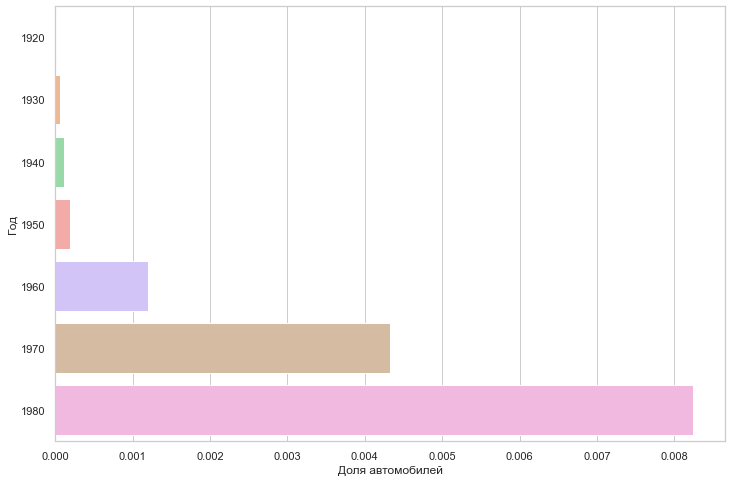

In [34]:
d = {}
step = 10
for i in np.arange(1920, 1990, step):
    l = len(df[(df['registrationyear'] >= i-step/2) & (df['registrationyear'] < i+step/2)])
    m = len(df)
    d[i] = l/m

tmp = pd.DataFrame([d]).T.reset_index().rename(columns={0:'Доля автомобилей', 'index':'Год'})
sns.barplot(data=tmp, x='Доля автомобилей', y='Год', orient = 'h');

Видим, что, например, если удалить все даты до 1965 года, мы потеряем всего около 0.1% записей, большая часть из которых неадекватна.

Посмотрим еще на машины из будущего.

In [35]:
df.sort_values('registrationyear', ascending=False).head(10)

datecrawled  price vehicletype  registrationyear gearbox  \
103180 2016-03-21 23:58:16   6800       sedan            2019.0  manual   
28593  2016-03-07 07:36:24   5500       sedan            2019.0  manual   
59426  2016-03-27 12:57:50   7900       wagon            2019.0    auto   
168495 2016-03-12 22:40:12  15500       small            2019.0  manual   
259214 2016-03-19 13:46:15    500       sedan            2019.0  manual   
70271  2016-04-01 18:42:52   4800       wagon            2019.0  manual   
140317 2016-04-02 20:39:12   1999       small            2019.0  manual   
33498  2016-03-31 08:37:04   1200       wagon            2019.0  manual   
96231  2016-03-20 15:53:14   1800       sedan            2019.0  manual   
59253  2016-04-01 16:57:33   2000         bus            2019.0  manual   

        power        model  kilometer  registrationmonth  fueltype  \
103180      0           a3     150000                  7  gasoline   
28593       0         ceed     125000                  0    petrol   
59426     170       passat     150000                 12  gasoline   
168495     90         polo       5000                  0    petrol   
259214      0          5er     150000                  5  gasoline   
70271     160       mondeo     150000                  0    petrol   
140317     80        punto      90000                  8    petrol   
33498     140          156     150000                  5    petrol   
96231     122     c_klasse     150000                  0    petrol   
59253      90  transporter     150000                  0  gasoline   

                brand notrepaired datecreated  postalcode            lastseen  \
103180           audi          no  2016-03-21       97464 2016-04-05 15:18:02   
28593             kia         NaN  2016-03-07       65239 2016-03-11 06:44:48   
59426      volkswagen          no  2016-03-27       42103 2016-04-01 12:45:56   
168495     volkswagen          no  2016-03-12       58640 2016-03-12 22:40:12   
259214            bmw          no  2016-03-19       48301 2016-03-19 13:46:15   
70271            ford         NaN  2016-04-01       85235 2016-04-03 15:16:36   
140317           fiat         NaN  2016-04-02       66538 2016-04-06 20:47:20   
33498      alfa_romeo          no  2016-03-31       91058 2016-04-06 03:15:42   
96231   mercedes_benz          no  2016-03-20       55767 2016-04-06 20:45:31   
59253      volkswagen          no  2016-04-01       88436 2016-04-01 17:42:04   

       sample  
103180  train  
28593   train  
59426   train  
168495   test  
259214  train  
70271   train  
140317  train  
33498   train  
96231    test  
59253   train

Тоже какие-то неадекватные значения. Тут, видимо, без вариантов - придется все значения, начиная с 2017 года, заменять на пропуски.

In [36]:
df.loc[df['registrationyear'] < 1965, 'registrationyear'] = np.nan
df.loc[df['registrationyear'] >= 2017, 'registrationyear'] = np.nan

### (отклонимся в сторону) Тип авто

Мы тут рассматриваем численные фичи, но в определенный момент нам понадобится знать тип авто. А с ним тоже есть проблемы! Посмотрим на то, какие типы авто встречаются у конкретных моделей

In [37]:
df.groupby(['brand', 'model'])['vehicletype'].apply(lambda x: x.value_counts())

brand       model          
alfa_romeo  145       small     24
                      sedan     12
                      coupe      2
                      other      1
            147       sedan    432
                              ... 
volvo       v70       wagon    611
                      coupe      1
            xc_reihe  suv      222
                      wagon     41
                      sedan      3
Name: vehicletype, Length: 1406, dtype: int64

Видим, что у одной модели может встречаться хоть шесть разных вариантов. Небольшие машины могут выпускаться в разных вариантах:
- седан
- small хэтчбэк (обрезанный багажник)
- купе (как седан, но 2 двери)
- wagon универсал (увеличенный багажник)
- convertible кабриолет (съемная крыша)

Отдельно можно отметить:
- SUV - спортивно-утилитарный автомобиль. Выносливый автомобиль с кузовом, похожим на универсал, но построенный на шасси лёгкого грузовика (пикапа)
- bus - микроавтобус. Иногда настолько микро, что на той же базе (та же модель) есть седан

При этом универсал, микроавтобус и suv легко путаются между собой.

Сходу не понятно, что можно вытащить из имеющихся данных - слишком много моделей. Для рабочего решения следовало бы просмотреть их все (или хотя бы самые популярные) и уточнить, какие вариации у них есть. А потом вставить их на наш сайт по продаже авто, чтобы пользователь не вводил что хочет, а для каждой модели мог выбрать из перечня модификаций.

### Мощность двигателя

Надо получить оценку адекватности мощности двигателей.

Самые мощные двигатели: https://1gai.ru/publ/518650-top-29-samyh-moschnyh-gruzovyh-avtomobiley-v-mire-v-2017-godu.html
- пишут, что для грузовика 700 лс - это практически рекорд. И это грузовики!
- в принципе у легковых авто типа BMW M5 тоже бывает высокая мощность - 600 лс. Сделаем это отсечкой

Самые слабые двигатели: https://fastmb.ru/autonews/autonews_mir/1367-samye-malomoschnye-avtomobili-top-10.html
- адекватные начинаются где-то с 9 лс, хотя я не думаю, что в 2016 году таких машин было много. Мне кажется, адекватное значение отсечки - что-то в районе 50. Все, что меньше - это редкие модели, и бустинги смогут привязать их цену именно к модели, а не к мощности.

Кроме того, в данных много машин с мощностью до 25 лс. Если посмотреть на них, то там видны обыкновенные модели с мощностью 100-200. Я бы предположил, что для них надо мощность умножить на 10.

In [38]:
df.loc[df['power'] < 9, 'power'] = np.nan
df['power'] = df['power'].where(df['power'] >= 24, df['power'] * 10)
df.loc[df['power'] <= 50, 'power'] = np.nan
df.loc[df['power'] >= 600, 'power'] = np.nan

Посмотрим, как распределены мощности для разных типов авто (помним о том, что написано выше про типы).

In [39]:
df['sample'].value_counts()

train    250783
test      83595
Name: sample, dtype: int64

sedan :


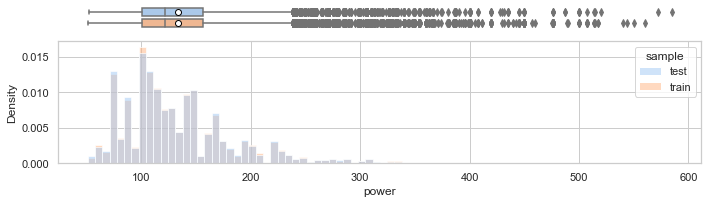

coupe :


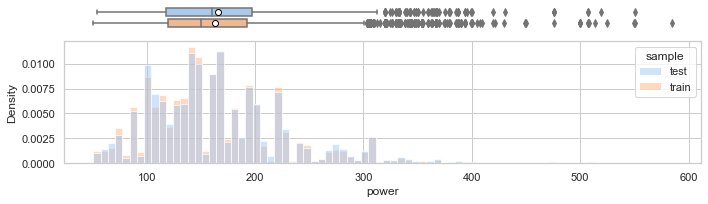

suv :


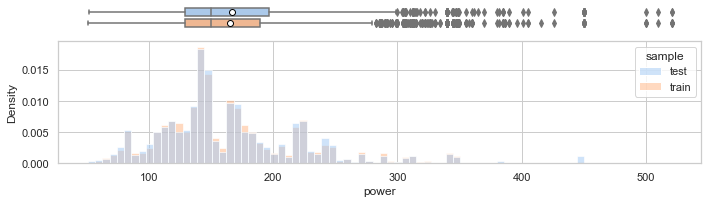

small :


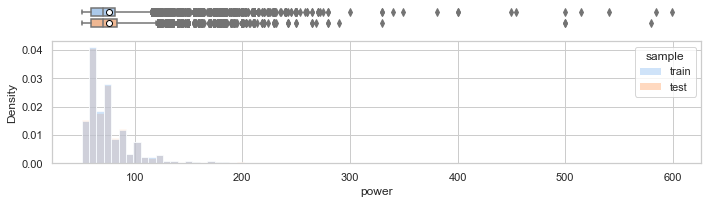

convertible :


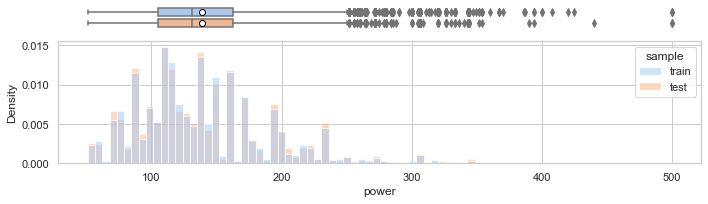

bus :


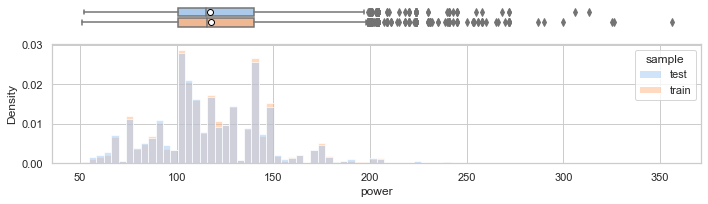

wagon :


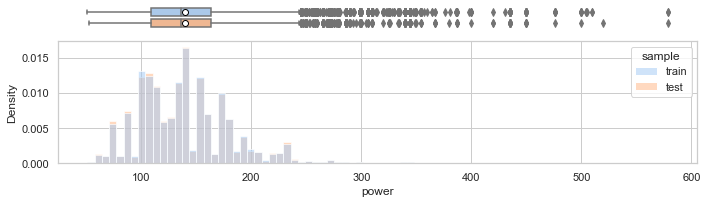

other :


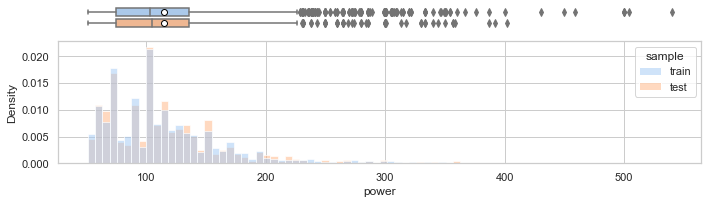

In [40]:
l = df['vehicletype'].fillna('NaN').unique()
for i, t in enumerate(l):
    print(t, ':')
    feature_analyze(df[df.fillna('NaN')['vehicletype'] == t], 'power', text_out=False, figsize=(10, 3))

Сразу видим некий абсурд. Например, в категории small на глаз распределение заканчивается на 200 лс, а фактически идет до 600. Если посмотреть на эти машины, то, конечно, оказывается, что там лежат неадекватные мощности. Почистим их.

In [41]:
df.loc[(df['power'] >= 300) & (df['vehicletype'] == 'small'), 'power'] = np.nan

Дальнейшая очистка потребует слишком много ресурсов и ручной работы. Например, можно было бы учесть, что очень немногие производители делают двигатели мощнее 300 лс (например, бмв), и на основе этого еще немного почистить данные.

### Пробег

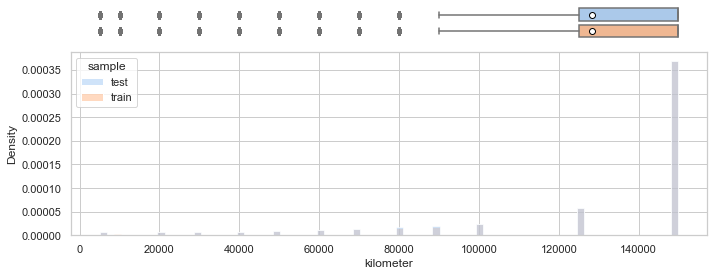

Количество пропусков в выборках


sample
test     0
train    0
Name: kilometer, dtype: int64

In [42]:
feature_analyze(df, 'kilometer', box=True)

Ну хоть тут все, вроде, понятно. Стоит отметить, что этот признак, скорее, категориальный. Кроме того, значение 150к - это технический максимум, куда сливаются все значения 150к и выше. Таким образом, пробег 150к и пробег 300к попадут в одну категорию. Неудачно.

Вообще-то этот пробег является не количественным признаком, а ранговым. Но бустинги это и так поймут, а для линейной регрессии ранговый все равно придется перевести в количественный.

### Месяц регистрации

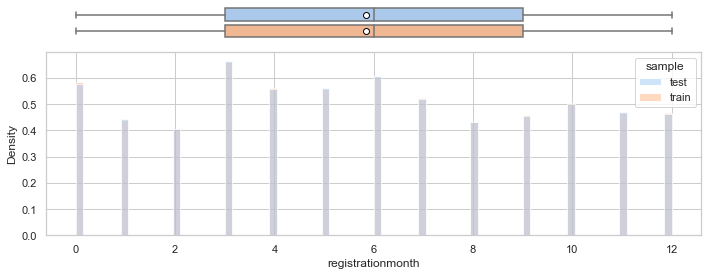

Количество пропусков в выборках


sample
test     0
train    0
Name: registrationmonth, dtype: int64

In [43]:
feature_analyze(df, 'registrationmonth', box=True)

Интересно, что значений 13 штук, тогда как месяцев 12. Вероятно, нулевое значение - это пропуски (видно, что среднее сдвинуто влево относительно 6). Предлагаю нулевое значение заменить на nan, а дальше уже попробовать разные варианты заполнения.

In [44]:
df.loc[df['registrationmonth'] == 0, 'registrationmonth'] = np.nan

### Категориальные признаки

Остальные признаки категориальные (даже если кажутся числовыми, как индекс). Посмотрим, что у них и как.

In [45]:
def category_analyze(col_name, num=20):
    tmp = df[col_name].fillna('NaN').value_counts(dropna=False, normalize=True)
    tmp = tmp.sort_index(ascending=False).sort_values(ascending=False)
    if len(tmp) > num:
        tmp2 = tmp.iloc[:num]
        tmp2['Остальные'] = tmp.iloc[num:].sum()
    else:
        tmp2 = tmp
    sns.barplot(x=tmp2, y=tmp2.index, orient = 'h')
    print('Num of unique values', len(tmp))
    print('Num of nans', df[col_name].isna().sum())

### Тип авто

Num of unique values 8
Num of nans 0


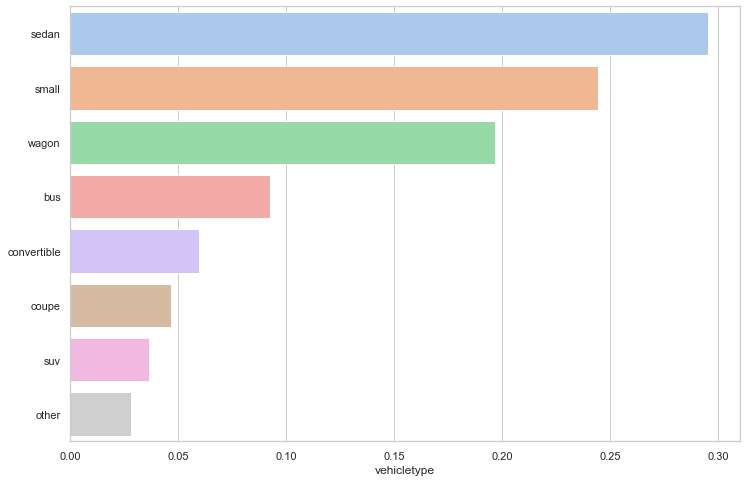

In [46]:
category_analyze('vehicletype')

Функция работает. Радует, что other на последнем месте.

### Коробка передач

Num of unique values 3
Num of nans 3605


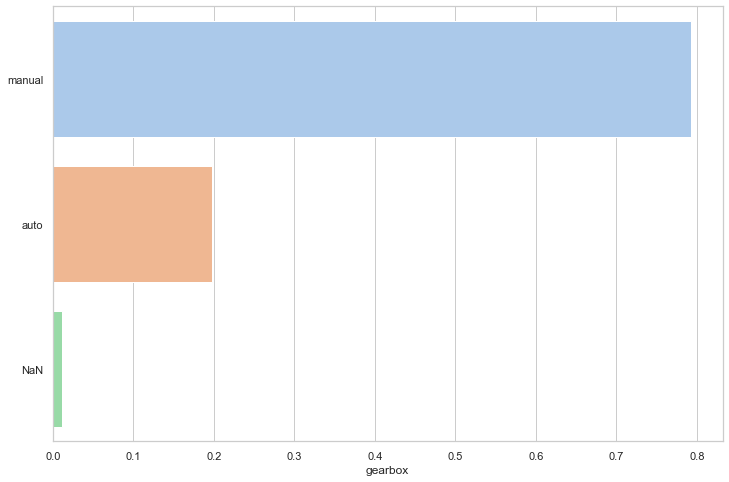

In [47]:
category_analyze('gearbox')

Я бы предположил, что здесь все пропуски - это ручная коробка. Но это может ухудшить качество модели.

### Модель

Num of unique values 245
Num of nans 0


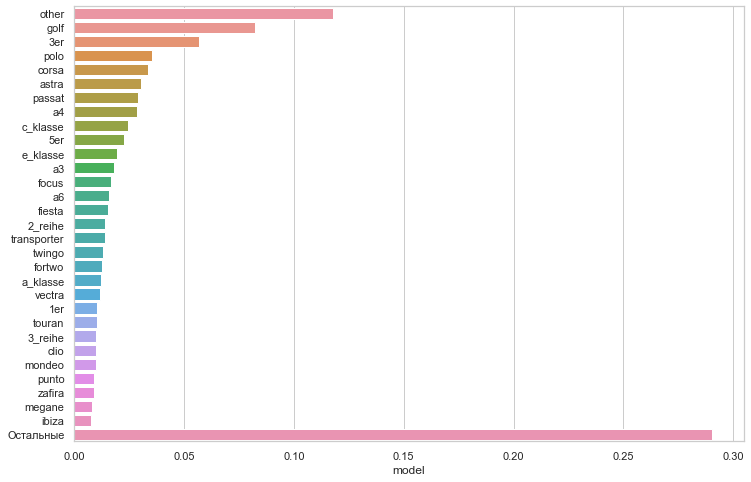

In [48]:
category_analyze('model', num=30)

Видим, что категория other занимает около 12% датасета, а наши заполненные NaN-ы - почти 30%! Всего моделей более 200.

### Тип топлива

Для начала уточним, что обычно petrol и gasoline - это одно и то же - бензин: https://en.wikipedia.org/wiki/Gasoline

В то же время: Some languages,like French and Italian, use the respective words for gasoline to indicate diesel fuel.

Так как слова "дизель" у нас в видах топлива нету, значит, газолин - это и есть дизель.

Num of unique values 8
Num of nans 6786


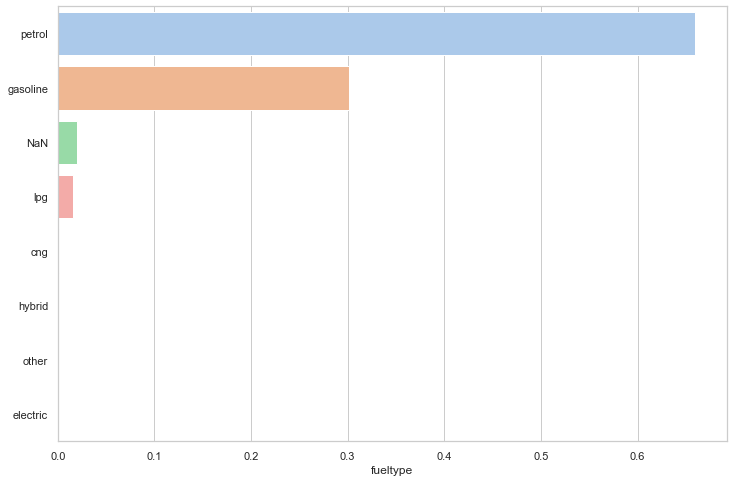

In [49]:
category_analyze('fueltype')

Есть мысль объединить все редкие категории в other. Обоснование - вероятно, у конкретной модели есть только одна необычная модификация, и бустинг успешно привяжет ее стоимость не к топливу, а к модели. А вот топливо надо, чтобы отличать дизель от бензина.

In [50]:
for i in ['cng', 'lpg', 'hybrid', 'electric']:
    df.loc[df['fueltype'] == i, 'fueltype'] = 'other'

### Бренд

Num of unique values 40
Num of nans 0


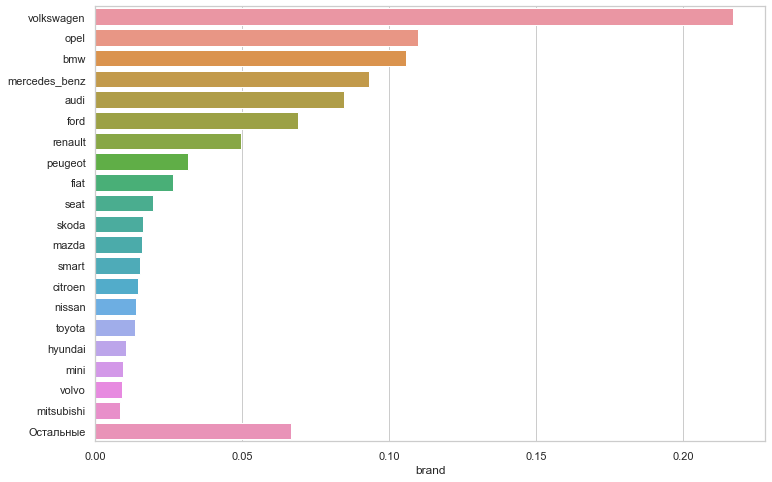

In [51]:
category_analyze('brand')

Ну хоть тут все в порядке.

### После ремонта

Num of unique values 3
Num of nans 61372


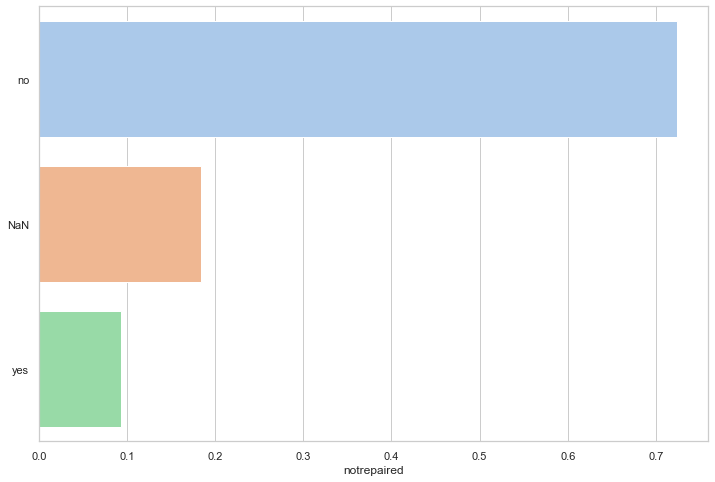

In [52]:
category_analyze('notrepaired')

И опять куча пропусков - почти 20%. Логика подсказывает, что пропуски - это отсутствие ремонта.

С другой стороны, логика подсказывает, что это не всегда так. Возможно, например, что это когда автор объявления указал отсутствие ремонта, но это не подтвердили страховщики. Возможно, не стоит слепо заполнять эти пропуски значением no.

### Почтовые коды

Вероятно, почтовые коды бесполезны для нашей задачи. Но посмотрим, сколько у них значений и сколько из них вообще повторяются.

In [53]:
df['postalcode'].value_counts().head(6)

10115    810
65428    594
66333    312
44145    295
32257    289
52525    286
Name: postalcode, dtype: int64

In [54]:
print('Число индексов', len(df['postalcode'].unique()))
tmp = df['postalcode'].value_counts()
print('Число индексов, которые повторяются не менее 20 раз', (tmp >= 20).sum())

Число индексов 8132
Число индексов, которые повторяются не менее 20 раз 4529


А вот еще идея - скачать координаты почтовых индексов! Запишем их в отдельные колонки.

In [55]:
df['c1'] = np.nan
df['c2'] = np.nan
url = 'https://download.geonames.org/export/zip/DE.zip'
filehandle, _ = urllib.request.urlretrieve(url)
zip_file_object = zipfile.ZipFile(filehandle, 'r')
first_file = zip_file_object.namelist()[1]
file = zip_file_object.open(first_file)

for l in tqdm(file):
    s = l.decode("utf-8").split('\t')
    ind = int(s[1])
    if ind in df['postalcode'].unique():
        df.loc[df['postalcode'] == ind, 'c1'] = float(s[-3])
        df.loc[df['postalcode'] == ind, 'c2'] = float(s[-2])

file.close()

16478it [00:57, 288.52it/s]


Проверим, сколько координат не заполнилось. Из тестовой удалять их не будем, чтобы на кросс-валидации проверить, что все нормально срабатывает.

In [56]:
df['c1'].isna().sum()

118

Видимо, эти ненайденные индексы указаны с опечатками. Я их поискал - таких, действительно, нет в Германии (да и вообще в Европе).

А теперь нанесем точки на карту.

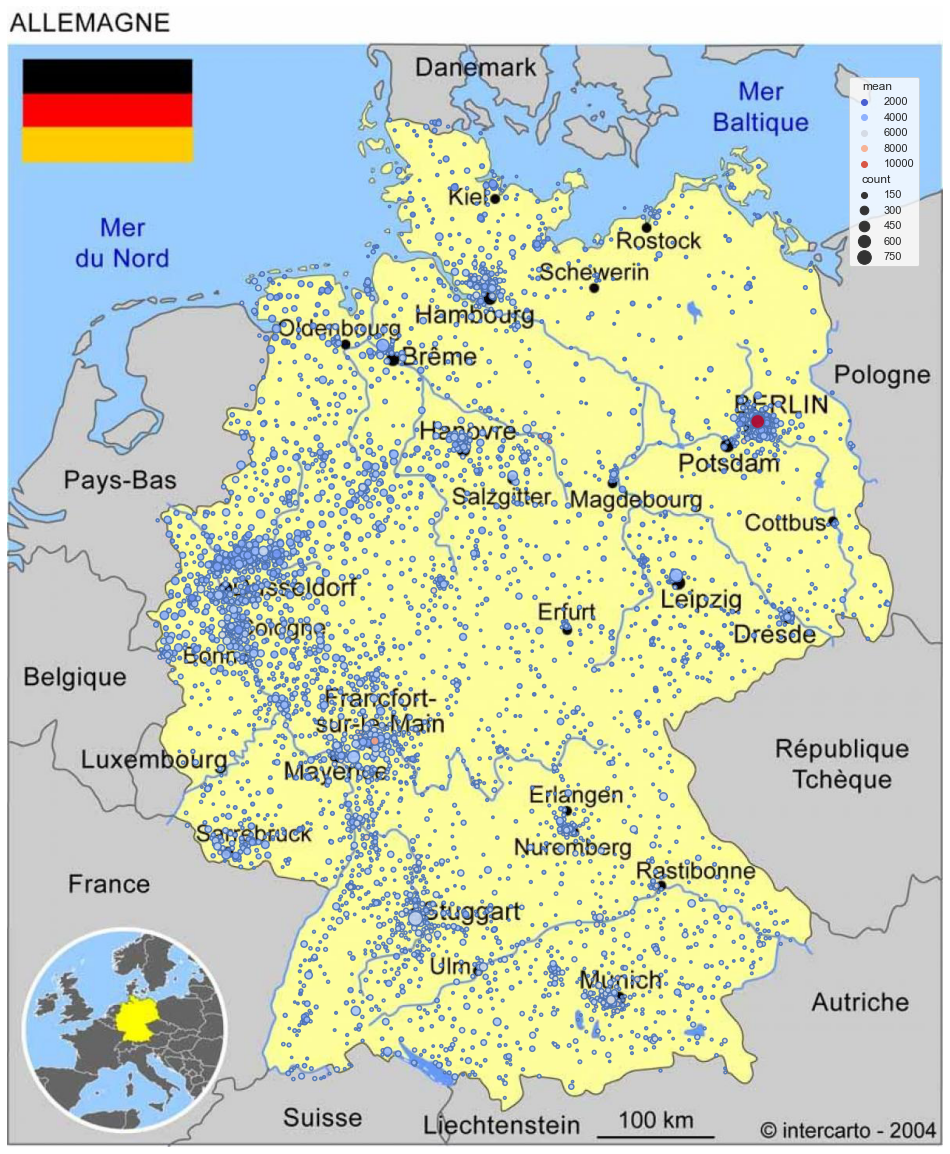

In [57]:
url = 'https://germanymap360.com/img/1200/germany-map.jpg'
r = requests.get(url, allow_redirects=True)
open('germany-map.jpg', 'wb').write(r.content)
img = matplotlib.image.imread('germany-map.jpg')

fig, ax = plt.subplots(figsize=(13, 18))
ax1 = fig.add_axes([0., 0., 1., 1.])
ax2 = fig.add_axes([0.12, 0.06, 0.86, 0.83])
ax1.set_axis_off()
ax2.set_axis_off()
ax2.patch.set_alpha(0.0)
ax1.imshow(img)

tmp = df.pivot_table(index=['c1', 'c2'], values='price', aggfunc=['count', 'mean']).reset_index()
tmp.columns = [i[0] for i in tmp.columns]
tmp = tmp.sort_values('count', ascending=True).reset_index(drop=True)
tmp = tmp[tmp['count'] > 20]
sns.scatterplot(data=tmp, x='c2', y='c1', size='count', hue='mean',
                sizes=(5, 200), alpha=.9, ax=ax2, palette='coolwarm', edgecolor='b',
                **{"linewidth": 1.5});

Наверное, это можно было сделать умнее и точнее (тут видно, что карта немного повернута), но результат достигнут, карта видна.

Проверим, что мы не удалили ни одной строки из тестовой выборки.

In [58]:
print(number_test_lines_before)
df['sample'].value_counts()[-1]

83595


83595

Отлично, все на месте.

### Совместный анализ признаков

Мы уже убрали из данных самые безумные значения, но, очевидно, там остались выбросы. Сделаем временный датафрейм без них для совместного анализа.

In [59]:
df2 = df.copy()
print(len(df2))
for c in ['datecrawled', 'datecreated', 'lastseen']:
    df2[c] = (df2[c] - df2[c].min()) / np.timedelta64(1,'D')
for c in df2.columns:
    try:
        q_min = df2[c].quantile(0.01)
        q_max = df2[c].quantile(0.99)
        df2 = df2[df2[c] >= q_min]
        df2 = df2[df2[c] <= q_max]
    except: pass
df2 = df2[df2['model'] != 'other']
df2 = df2[df2['brand'] != 'other']
print(len(df2))

334378
208042


CPU times: total: 6.3 s
Wall time: 6.44 s


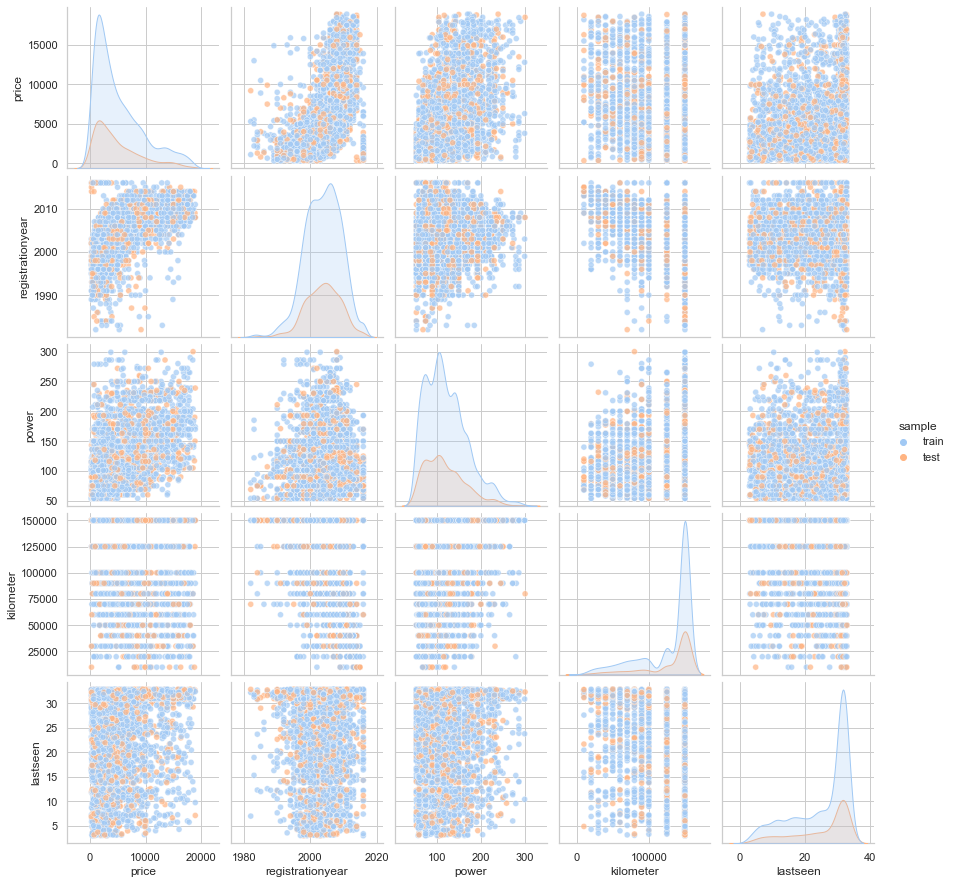

In [60]:
%%time
sns.pairplot(
    data=df2.drop(columns=['datecreated', 'datecrawled','postalcode', 'registrationmonth', 'c1', 'c2']).dropna().sample(n=5000),
    hue='sample', plot_kws={'alpha':0.7}
);

Не самый наглядный рисунок. В принципе видно, что цена зависит от года регистрации и от мощности двигателя. Еще интересно, что в районе 2000-х мощности были максимальными, а потом стали снижаться.

Цена также немного зависит и от даты последней активности пользователя - чем новее, тем выше цена. Вероятно, это связано с тем, что машины по низкой цене быстрее покупают, поэтому дата активности

Километраж представлен в виде дискретной величины, поэтому понять зависимость не получается (хотя видно, что, чем старее машина, тем больше у нее пробег. Кроме того, есть положительная корреляция мощности и километража).

Интересно, что те объявления, которые пользователи видели последними (то есть, вероятно, не проданные машины и не закрытые объявления) чаще включают в себя старые авто.

Попробуем посмотреть на корреляции признаков.

Сначала обычная корреляция Пирсона.

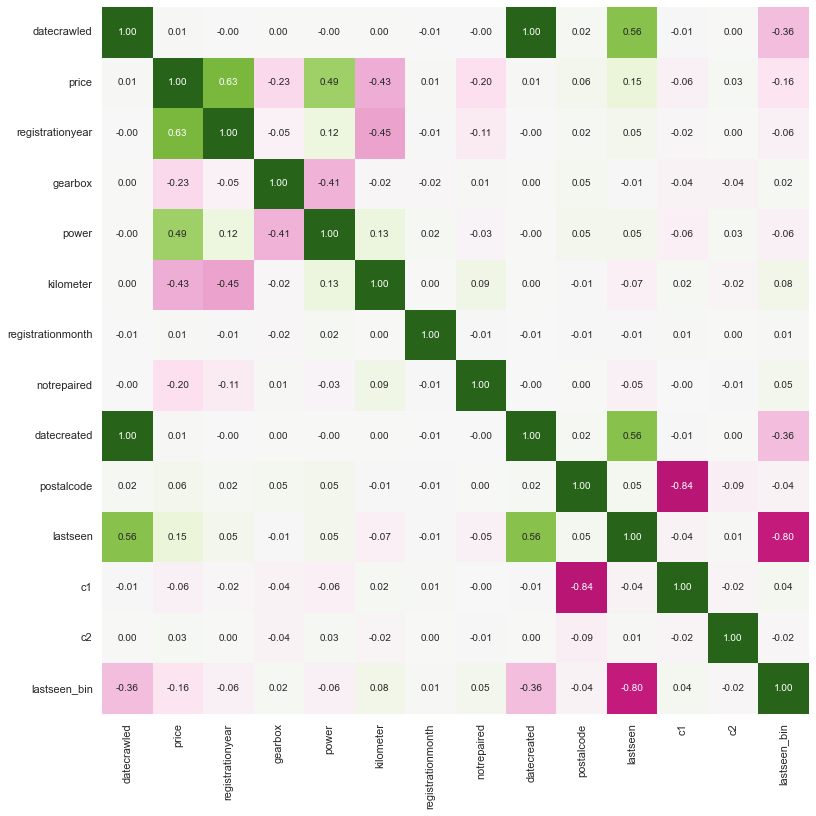

In [61]:
df2['lastseen_bin'] = (df2['lastseen'] - df2['lastseen'].min())
df2['lastseen_bin'] = (df2['lastseen_bin'] < df2['lastseen_bin'].median())

fig = plt.figure(figsize=(13,13))
tmp = df2.copy()
p = preprocessing.OrdinalEncoder()
cat_cols = ['gearbox', 'registrationmonth', 'notrepaired']
tmp[cat_cols] = p.fit_transform(tmp[cat_cols])

sns.heatmap(tmp.corr(),
    square=True, cmap="PiYG",
    center=0,
    cbar=False,
    annot=True, fmt='.2f', annot_kws={'size': 10});

Видим, что цена линейно коррелирует с:
- годом выпуска
- мощностью двигателя
- типом коробки
- километражом
- наличием ремонта
- датой последней активности пользователя (слабо). В такой же степени - с бинарным кодированием последней активности

Кроме того:
- тип коробки коррелирует с мощностью двигателя
- все три временных столбца коррелируют друг с другом, в частности, datecrowled и datecreated коррелируют почти идеально, тоесть кроулер шел по датам созданий объявлений
- сами по себе координаты линейно ни с чем не коррелируют (кроме индексов)

А теперь более интересно - нелинейный коэффициент корреляции. Скормим ему категориальные признаки, закодированные целыми числами через OrdinalEncoder.

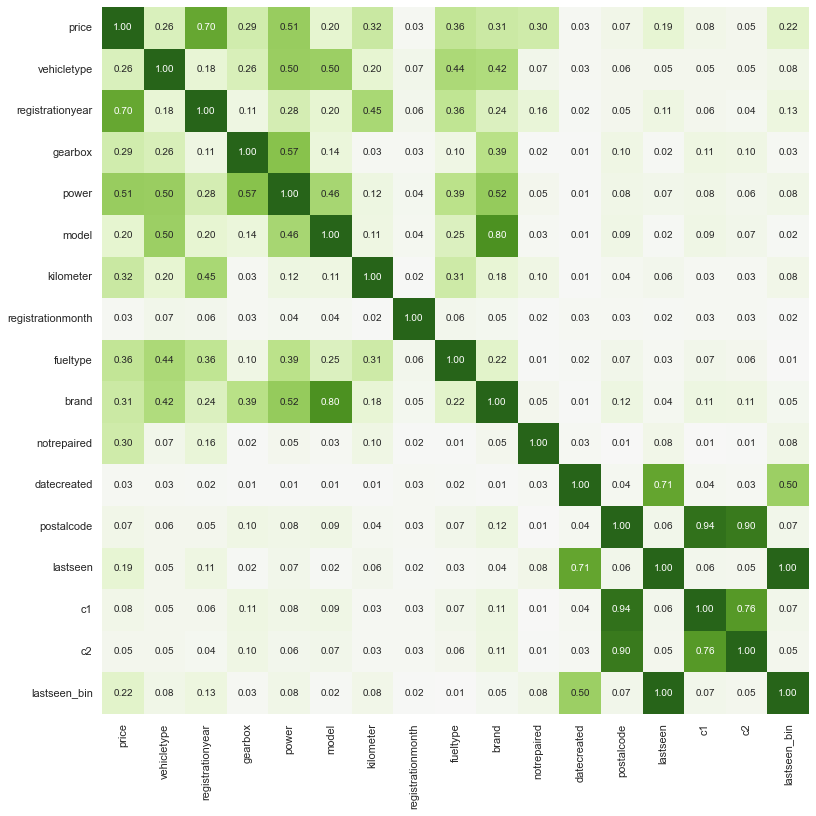

In [62]:

tmp = df2.copy().drop(columns='sample')
p = preprocessing.OrdinalEncoder()
cat_cols = ['vehicletype', 'gearbox', 'model', 'registrationmonth', 'fueltype', 'brand', 'notrepaired', 'postalcode']
tmp[cat_cols] = p.fit_transform(tmp[cat_cols])

sns.heatmap(data=tmp.drop(columns=['datecrawled']).phik_matrix(interval_cols=tmp.columns),
    square=True, cmap="PiYG",
    center=0,
    cbar=False,
    annot=True, fmt='.2f', annot_kws={'size': 10});

Цена коррелирует со всеми признаками, кроме:
- месяц регистрации
- дата создания объявления

Есть очень слабая корреляция цены с почтовым индексом и с датой последней активности пользователя.

Корреляции остальных признаков:
- год регистрации - километраж
- коробка - мощность и бренд
- мощность - почти все признаки
- модель - почти все признаки
- тип топлива - почти все признаки
- бренд - почти все признаки
- ремонт - год регистрации и совсем слабо - километраж
- почтовый индекс - очень слабая корреляция (но не нулевая) со многими признаками

Самые бесполезные признаки:
- месяц регистрации. По идее можно выкидывать
- дата создания объявления
- почтовый индекс / координаты. Даже обидно, что идея с координатами оказалась не очень.

### Что делать с малополезными признаками

Отдельно остановимся на двух последних пунктах

Дата создания объявления (а также дата последней активности и тем более дата кроулинга) - мы хотим сделать предсказательную модель для того, чтобы пользователь, зайдя на сайт, мог получить оценку своей машины. В этот момент дата создания будет лежать далеко вне диапазона дат обучения, а дата последней активности будет вообще неактуальна. Я вижу два решения:
- просто выкинуть все эти столбцы из рассмотрения. Дешево и сердито, но мы потеряем спрятанную в lastseen корреляцию
- выкинуть datecrawled и datecreated, а lastseen закодировать в виде "хотите ли вы продать машину быстро". Это повысит качество предсказаний, но потребует от пользователя заполнить еще одну графу

Почтовый индекс - весь массив индексов кажется малополезным. В то же время мы видели, что некоторые значения встречаются сотни раз, и корреляция все-таки присутствует. Пока что идея такова: использовать OHE, но кодировать только несколько самых популярных регионов.

### Виды кодирования качественных переменных

OHE плохо подходит для кодирования качественных переменных, когда у них много значений (например, в случае почтового индекса). При этом мы сталкиваемся с проклятием размерности, когда расчеты становятся все дольше из-за большого количества фич. А пользы от них становится мало, начинается переобучение.

Есть другие варианты кодирования:
- Limit to x-most frequent features. Тот же OHE, только оставляем самые популярные столбцы (топ-5, топ-100 - подбираем вручную), а остальные выкидываем (они получают 0 во всех столбцах)
- Frequency Encoding. Каждую категорию кодируем количеством объектов в ней. Неоднозначный подход, но пишут, что во многих случаях работает. Например, в случае с индексом он будет означать кодирование индекса как количества машин в регионе, то есть благосостояние/плотность населения - в принципе логика есть
- Target Encoding. Каждую категорию кодируем средним значением целевого признака внутри этой категории. Как я понимаю, это хорошо работает, когда категорий не очень много, и они есть и в обучающей, и в целевой выборках
- Embedding. Нейросетью попробовать представить разреженную матрицу OHE в виде плотной матрицы признаков. Делаем энкодер-декодер, обучаем без учителя (заставляем на выходе предсказывать тот же набор признаков, что и на входе), выкидываем декодер, а энкодер будет делать нам эмбеддинг.

Было бы здорово попробовать их все. Например, вот такая логика:
- Limit to x-most frequent features. Почтовые индексы. Возможно, модели машин (особенно, когда конкретная модель встречается всего 1-2 раза)
- Frequency Encoding. Почтовые индексы, потому что есть логика такого преобразования
- Target Encoding. По идее хорошо подойдет для брендов, потому что они все заполнены, и их не очень много. Для индексов - не очень
- Embedding. Тут надо использовать все признаки разом. Мне кажется, в этой работе слишком мало данных для такого количества категорий, чтобы прменять эмбеддинги

Развлечемся немного и сделаем обертку для всех трех не-нейронных энкодеров, совместимую с пайплайном.

In [63]:
class custom_encoder(BaseEstimator, TransformerMixin):
    def __init__(self, encoder_type='target', fill_type='mean', num_most_freq=100):
        self.encoder_type = encoder_type
        self.num_most_freq = num_most_freq
        self.encoder = None
        self.fill_type = fill_type

    def fit(self, X, y=None):
        if 'Series' in str(type(X)):
            X2 = pd.DataFrame()
            X2['0'] = X
        else:
            X2 = X

        for c in X2.columns:
                if X2[c].dtype == int: X2[c] = X2[c].apply(str)

        if self.encoder_type == 'ohe' or self.encoder_type == 'OHE':
            l = []
            for c in X2.columns:
                l.append(list(X2[c].value_counts().head(self.num_most_freq).index))
            self.encoder = preprocessing.OneHotEncoder(categories=l, handle_unknown='ignore')
            self.encoder.fit(X2, y)

        elif self.encoder_type == 'freq':
            self.d = {}
            for c in X2.columns:
                self.d[c] = X2[c].value_counts()

        elif self.encoder_type == 'target':
            X2['target'] = y
            self.d = {}
            if self.fill_type == 'mean':
                self.m = y.mean()
            elif self.fill_type == 'median':
                self.m = y.median()
            else: self.m = y.mode()[0]
            for c in X2.columns:
                if c == 'target': continue
                self.d[c] = X2.groupby(c)['target'].mean()

        return self

    def transform(self, X, y=None):
        if 'Series' in str(type(X)):
            X2 = pd.DataFrame()
            X2['0'] = X
        else:
            X2 = X

        for c in X2.columns:
            if X2[c].dtype == int: X2[c] = X2[c].apply(str)

        if self.encoder_type == 'ohe' or self.encoder_type == 'OHE':
            X2 = self.encoder.transform(X2)

        elif self.encoder_type == 'freq':
            for c in X2.columns:
                X2[c] = X2[c].apply(lambda x : self.d[c][x] if x in self.d[c] else 0)

        elif self.encoder_type == 'target':
            for c in X2.columns:
                X2[c] = X2[c].apply(lambda x : self.d[c][x] if x in self.d[c] else self.m)

        return X2

Отметим, что в таком подходе нет утечки данных - каждый раз при обучении трансформер будет обучаться только на доступных данных. Но это будет долго.

Кроме того, линейная регрессия наверняка выдаст нам неадекватные значения, например, отрицательные. Чтобы избежать этого, сожмем все предсказания в диапазон значений целевого признака из обучающей выборки. Для этого придется написать оболочку к регрессору.

In [64]:
SklearnInput = Union[list, np.ndarray, pd.DataFrame, pd.Series]

class estimator_wrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, estimator: BaseEstimator, lim=True, **kwargs: Any):
        self.estimator = estimator
        self.lim = lim
        self.estimator.set_params(**kwargs)

    def fit(self, X: SklearnInput, y: SklearnInput, **fit_params: Any):
        y = check_array(y, accept_sparse=False, force_all_finite=True, ensure_2d=False, dtype='object')
        self.m1 = np.min(y)
        self.m2 = np.max(y)
        self._training_dim = y.ndim
        if y.ndim == 1:
            y_2d = y.reshape(-1, 1)
        else:
            y_2d = y
        y_2d=y_2d.astype('int')
        self.estimator.fit(X=X, y=y_2d, **fit_params)
        self.is_fit_ = True
        return self

    def predict(self, X: SklearnInput):
        check_is_fitted(self.estimator)
        pred = self.estimator.predict(X)
        if self.lim:
            pred = np.where(pred >= self.m1, pred, 0)
            pred = np.where(pred <= self.m2, pred, self.m2)
        if pred.ndim == 1:
            pred = pred.reshape(-1, 1)
        if (self._training_dim == 1 and
                pred.ndim == 2 and pred.shape[1] == 1):
            pred = pred.squeeze(axis=1)
        return pred

## Обучение моделей

### Линейный бэйзлайн

Перед тем, как делать все правильно, попробуем оценить, какие варианты энкодинга для каких фич подходят. Здесь мы используем небольшой чит - будем сразу работать со всем датасетом, но в режиме кросс-валидации.

Сначала создаем сложный пайплайн:
- категориальные фичи кодируем (не стандартизуем, так как это помешает таргет кодированию)
- числовые фичи заполняем, стандартизируем
- проверяем, старое ли объявление (характеризует желаемую скорость продажи)
- объединяем все фичи
- линейная регрессия

In [65]:
df['lastseen_bin'] = (df['lastseen'] - df['lastseen'].min()) / np.timedelta64(1,'D')
df['lastseen_bin'] = (df['lastseen_bin'] < df['lastseen_bin'].median())

In [66]:
cat_cols = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired', 'postalcode', 'lastseen_bin']
num_cols = ['registrationyear', 'power', 'kilometer']

cat_cols_list = [(col_name, custom_encoder(encoder_type='target'), col_name) for col_name in cat_cols]
cat_cols_transformer = compose.ColumnTransformer(cat_cols_list)

num_cols_list = [(col_name, impute.SimpleImputer(), [col_name]) for col_name in num_cols]
num_cols_transformer = compose.ColumnTransformer(num_cols_list)

numeric_pipeline = pipeline.Pipeline([
    ('num_trans', num_cols_transformer),
    ('scaler', preprocessing.StandardScaler())
    ])

data_preprocessing = pipeline.FeatureUnion([
    ('num_line', numeric_pipeline),
    ('cat_line', cat_cols_transformer),
    ])

pipe = pipeline.Pipeline([
    ('data', data_preprocessing),
    ('estimator', estimator_wrapper(linear_model.LinearRegression()))
    ])

dict_keys = pipe.get_params().keys()

In [67]:
try:
    df['lastseen'] = (df['lastseen'] - df['lastseen'].min()) / np.timedelta64(1,'D')
except: pass

Внутри множество параметров. Но мы хотим покрутить только основные, в первую очередь, наши принципы заполнения. Внесем их в цикле.

In [68]:
param_distributions = {}
for param_name in dict_keys:
    if '__strategy' in param_name:
        param_distributions[param_name] = optuna.distributions.CategoricalDistribution(['mean', 'median', 'most_frequent'])
    if '__encoder_type' in param_name:
        param_distributions[param_name] = optuna.distributions.CategoricalDistribution(['ohe', 'freq', 'target'])
    if '__fill_type' in param_name:
        param_distributions[param_name] = optuna.distributions.CategoricalDistribution(['mean', 'median', 'most_frequent'])
    # практика показала, что количество активных столбцов в OHE совершенно не помогает, поэтому не будем их варьировать
    # if 'num_most_freq' in param_name:
    #     param_distributions[param_name] = optuna.distributions.IntUniformDistribution(30, 100)

А теперь считаем оптуной лучшие параметры.

In [69]:
%%time
optuna_search = optuna.integration.OptunaSearchCV(
        pipe,
        param_distributions,
        cv=3,
        n_trials=None,
        timeout=timeout if is_final else timeout_small,
        random_state=random_state,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        refit=False,
        verbose=0
        )

hyper_start = time.time()
optuna_search.fit(df[df['sample'] == 'train'], df[df['sample'] == 'train']['price'])
hyper_time = time.time() - hyper_start

print("Количество запусков: {}".format(len(optuna_search.study_.trials)))
print("Лучший результат:")
trial = optuna_search.study_.best_trial
print("  метрика: {}".format(trial.value))
parameters = optuna_search.best_params_
print(parameters)

Количество запусков: 98
Лучший результат:
  метрика: -2666.143806326389
{'data__num_line__num_trans__registrationyear__strategy': 'mean', 'data__num_line__num_trans__power__strategy': 'median', 'data__num_line__num_trans__kilometer__strategy': 'mean', 'data__cat_line__vehicletype__encoder_type': 'target', 'data__cat_line__vehicletype__fill_type': 'median', 'data__cat_line__gearbox__encoder_type': 'ohe', 'data__cat_line__gearbox__fill_type': 'mean', 'data__cat_line__model__encoder_type': 'ohe', 'data__cat_line__model__fill_type': 'mean', 'data__cat_line__fueltype__encoder_type': 'ohe', 'data__cat_line__fueltype__fill_type': 'most_frequent', 'data__cat_line__brand__encoder_type': 'ohe', 'data__cat_line__brand__fill_type': 'mean', 'data__cat_line__notrepaired__encoder_type': 'target', 'data__cat_line__notrepaired__fill_type': 'most_frequent', 'data__cat_line__postalcode__encoder_type': 'target', 'data__cat_line__postalcode__fill_type': 'median', 'data__cat_line__lastseen_bin__encoder_type

Отметим, что такая реализация очень долго считается из-за того, что каждый раз предобработка проходит заново на уровне датафреймов. Ниже приведен словарь, полученный в результате самого долгого запуска.

In [70]:
best_lin_params = {'data__num_line__num_trans__registrationyear__strategy': 'median', 'data__num_line__num_trans__power__strategy': 'most_frequent', 'data__num_line__num_trans__kilometer__strategy': 'mean', 'data__cat_line__vehicletype__encoder_type': 'ohe', 'data__cat_line__vehicletype__fill_type': 'most_frequent', 'data__cat_line__vehicletype__num_most_freq': 74, 'data__cat_line__gearbox__encoder_type': 'ohe', 'data__cat_line__gearbox__fill_type': 'median', 'data__cat_line__gearbox__num_most_freq': 63, 'data__cat_line__model__encoder_type': 'target', 'data__cat_line__model__fill_type': 'median', 'data__cat_line__model__num_most_freq': 60, 'data__cat_line__fueltype__encoder_type': 'target', 'data__cat_line__fueltype__fill_type': 'mean', 'data__cat_line__fueltype__num_most_freq': 70, 'data__cat_line__brand__encoder_type': 'ohe', 'data__cat_line__brand__fill_type': 'mean', 'data__cat_line__brand__num_most_freq': 43, 'data__cat_line__notrepaired__encoder_type': 'ohe', 'data__cat_line__notrepaired__fill_type': 'mean', 'data__cat_line__notrepaired__num_most_freq': 57, 'data__cat_line__postalcode__encoder_type': 'freq', 'data__cat_line__postalcode__fill_type': 'mean', 'data__cat_line__postalcode__num_most_freq': 100, 'data__cat_line__lastseen_bin__encoder_type': 'target', 'data__cat_line__lastseen_bin__fill_type': 'median', 'data__cat_line__lastseen_bin__num_most_freq': 79}
if is_final: best_lin_params = optuna_search.best_params_

Посмотрим, какие способы предобработки/кодирования выдали лучшие результаты. Соберем результаты в датфрейм и посмотрим на параметры нескольких запусков с лучшей метрикой.

In [71]:
tmp = optuna_search.study_.trials_dataframe().sort_values('value', ascending=False).reset_index(drop=True).head(10)
tmp2 = pd.DataFrame()
tmp2['value'] = tmp['value']
for c in tmp.columns:
    for j in cat_cols + num_cols:
        if (j in c) and (('encoder_type' in c) or ('strategy' in c)):
            tmp2[c[22:]] = tmp[c]
if is_final: tmp2.T.to_csv('lin_model_trials.csv')
try:
    display(pd.read_csv('lin_model_trials.csv'))
except:
    display(tmp2.T)

Unnamed: 0                   0  \
0                                    value  -2666.143806326389   
1                     _brand__encoder_type                 ohe   
2                  _fueltype__encoder_type                 ohe   
3                   _gearbox__encoder_type                 ohe   
4              _lastseen_bin__encoder_type                freq   
5                     _model__encoder_type                 ohe   
6               _notrepaired__encoder_type              target   
7                _postalcode__encoder_type              target   
8               _vehicletype__encoder_type              target   
9          _num_trans__kilometer__strategy                mean   
10             _num_trans__power__strategy              median   
11  _num_trans__registrationyear__strategy                mean   

                    1                  2                  3  \
0   -2687.82497782088  -2687.82497782088  -2687.82497782088   
1                freq               freq               freq   
2                 ohe                ohe                ohe   
3              target             target             target   
4                 ohe                ohe                ohe   
5              target             target             target   
6                 ohe                ohe                ohe   
7                freq               freq               freq   
8              target             target             target   
9       most_frequent      most_frequent      most_frequent   
10               mean               mean               mean   
11               mean               mean               mean   

                    4                  5                  6  \
0   -2687.82497782088  -2687.82497782088  -2687.82497782088   
1                freq               freq               freq   
2                 ohe                ohe                ohe   
3              target             target             target   
4                 ohe                ohe                ohe   
5              target             target             target   
6                 ohe                ohe                ohe   
7                freq               freq               freq   
8              target             target             target   
9       most_frequent      most_frequent      most_frequent   
10               mean               mean               mean   
11               mean               mean               mean   

                    7                    8                    9  
0   -2687.82497782088  -2687.8662270148993  -2688.0378815226795  
1                freq                 freq                 freq  
2                 ohe                  ohe                  ohe  
3              target                  ohe               target  
4                 ohe                  ohe                  ohe  
5              target               target               target  
6                 ohe                  ohe                  ohe  
7                freq                 freq                 freq  
8              target               target               target  
9       most_frequent        most_frequent        most_frequent  
10               mean                 mean                 mean  
11               mean                 mean                 mean

Интересно, что все три типа кодировки оказались полезными.

Проверим скорость работы и качество на тестовой выборке. Сначала создадим выборки из общего датафрейма и проверим, что не потеряли строки.

In [72]:
train_f = df[df['sample'] == 'train'].drop(columns=['price', 'sample'])
test_f = df[df['sample'] == 'test'].drop(columns=['price', 'sample'])
train_t = df[df['sample'] == 'train']['price'].drop(columns=['sample'])
test_t = df[df['sample'] == 'test']['price'].drop(columns=['sample'])
print('before', number_test_lines_before)
print('after', len(test_f))

before 83595
after 83595


Посмотрим на результат на тестовой выборке. Создаем единый датафрейм для всех результатов.

In [73]:
result = pd.DataFrame()

Напишем функцию для тестирования. Она измеряет время обучения на обучающей выборке и время инференса на тестовой, а также метрики качества. Возвращает словарь с результатам.

Кроме того, у нее есть параметр set_target_limits, отвечающий за искусственное ограничение выдаваемых предсказаний сверху и снизу диапзаоном таргета в обучающей выборке. Это очень полезно, когда модель почему-то решает предсказать отрицательную цену. Заметим, что эта фича уже встроена в нашу линейную модель.

In [74]:
def test_model(name, model, train_f=None, train_t=None, test_f=None, test_t=None, set_target_limits=True, is_cat=False, train_pool=None, test_pool=None, hyper_time=0):

    if is_cat:
        train_t = train_pool.get_label()
        test_t = test_pool.get_label()

    train_start = time.time()
    if is_cat:
        model.fit(train_pool)
    else:
        model.fit(train_f, train_t)
    train_end = time.time()

    if is_cat:
        p = model.predict(train_pool)
    else:
        p = model.predict(train_f)

    if set_target_limits:
        p = np.where(p >= train_t.min(), p, 0)
        p = np.where(p <= train_t.max(), p, train_t.max())
    rmse_train = metrics.mean_squared_error(train_t, p, squared=False)

    inference_start = time.time()
    if is_cat:
        p = model.predict(test_pool)
    else:
        p = model.predict(test_f)
    if set_target_limits:
        p = np.where(p >= train_t.min(), p, 0)
        p = np.where(p <= train_t.max(), p, train_t.max())
    inference_end = time.time()

    fig = plt.figure(figsize=(7,7))
    ax = sns.scatterplot(x=test_t, y=p)
    plt.plot([0, train_t.max()], [0, train_t.max()], color='red')
    ax.set(ylabel='Предсказанные значения на тестовой выборке')
    plt.show()
    rmse_test = metrics.mean_squared_error(test_t, p, squared=False)
    print(f'Метрика на тестовой выборке {rmse_test:.4f}')
    res = dict(
        name=name,
        train_time=train_end-train_start,
        inference_time=inference_end-inference_start,
        rmse_test=rmse_test,
        rmse_train=rmse_train,
        hyper_time=int(hyper_time)
    )
    return res

А теперь тест!

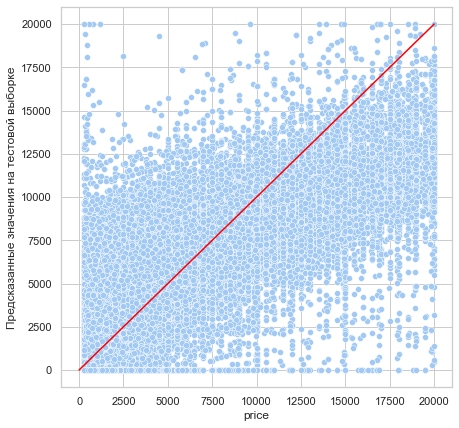

Метрика на тестовой выборке 2660.6660


name  train_time  inference_time    rmse_test   rmse_train  hyper_time
0  linear    2.974871        0.840189  2660.665996  2624.533065        2040

In [75]:
pipe.set_params(**best_lin_params)
res = test_model('linear', pipe, train_f, train_t, test_f, test_t, set_target_limits=False, hyper_time=hyper_time)
result = result.append(res, ignore_index=True).drop_duplicates()
display(result)

Видим, что у линейной модели очень много отрицательных результатов (которые мы искусственно "прижали" к нулю). Метрика качества плоха.

Кроме того, видим, что в области цен примерно до 1000 евро есть множество предсказаний значительно выше реальной цены.

### Lightgbm (easy)

Мой небольшой опыт (на задачах классификации) показывает, что лайтгбм - самый быстрый, но самый неточный из троицы лидеров градиентного бустинга.

Подготовим датафреймы для анализа. В конце проверим, что количество строк в тестовой выборке не изменилось.

Сразу уточним, что у lgbm будет проблема с категориальными фичами с высокой кардиналити (много уникальных значений), например, с почтовыми индексами - время расчета увеличится до безобразия. Поэтому необходимо в любом случае использовать какое-то кодирование.

Для начала просто оставим только самые часто встречающиеся значения, а остальные заменим на -1. А дальше пусть lgbm сам работает с этим столбцом как с категориальным.

Всего уникальных значений: 8132
Уникальных значений с количеством более 150: 284


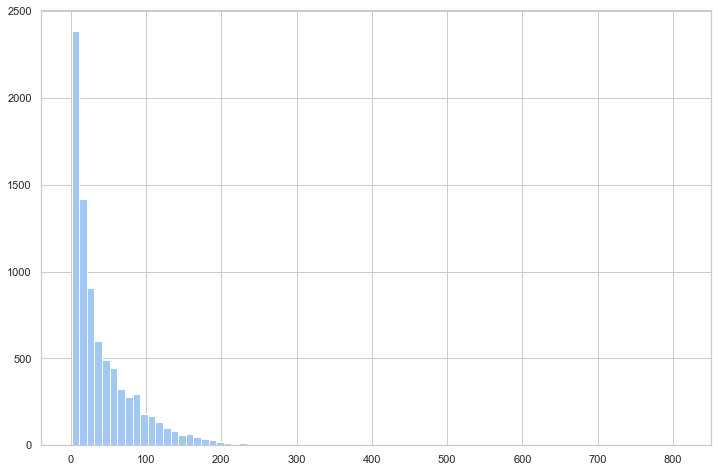

In [76]:
print('Всего уникальных значений:', len(df['postalcode'].unique()))
df['postalcode'].value_counts().hist(bins=80)
l = 150
print(f'Уникальных значений с количеством более {l}:', (df['postalcode'].value_counts() > l).sum())

In [77]:
df_lgbm = pd.DataFrame()
for c in ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired', 'lastseen_bin', 'postalcode']:
    df_lgbm[c] = df[c]
    if c == 'postalcode':
        l = 150
        good_codes = df[df['sample'] == 'train'][c].value_counts().head(l).index
        # внимание - тут используется только обучающая выборка. Никакого подглядывания!
        df_lgbm[c] = df_lgbm[c].apply(lambda x: x if x in good_codes else -1)
    df_lgbm[c] = df_lgbm[c].astype('category')
for c in ['registrationyear', 'power', 'kilometer']:
    df_lgbm[c] = df[c]

df_lgbm['sample'] = df['sample']
df_lgbm['price'] = df['price']
train_f = df_lgbm[df_lgbm['sample'] == 'train'].drop(columns=['price', 'sample'])
test_f = df_lgbm[df_lgbm['sample'] == 'test'].drop(columns=['price', 'sample'])
train_t = df_lgbm[df_lgbm['sample'] == 'train']['price'].drop(columns=['sample'])
test_t = df_lgbm[df_lgbm['sample'] == 'test']['price'].drop(columns=['sample'])
print('before', number_test_lines_before)
print('after', len(test_f))

before 83595
after 83595


Попробуем встроенный модуль оптимизации lgbm из оптуны LightGBMTunerCV. Не факт, что он выдаст лучший результат (не все параметры варьируются), зато быстро и легко.

In [78]:
%%time
dtrain = lgb.Dataset(train_f, label=train_t)

params = {
    "objective": "rmse",
    "metric": "rmse",
    'num_boost_round': 1000,
    'verbose': -1,
    "boosting_type": "gbdt",
    'random_state': random_state,
    'n_jobs': -1,
}

tuner = optuna.integration.lightgbm.LightGBMTunerCV(
    params,
    dtrain,
    folds=model_selection.KFold(n_splits=4),
    callbacks=[early_stopping(100)],
    time_budget=2*timeout if is_final else timeout_small,
    verbose_eval=False,
    verbosity=-1,
    optuna_seed=random_state,
    show_progress_bar=False,
)

hyper_start = time.time()
tuner.run()
hyper_time = time.time() - hyper_start

print("Best score:", tuner.best_score)
best_params = tuner.best_params
print("Best params:", best_params)

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's rmse: 1579.32 + 17.7006
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's rmse: 1562.96 + 17.46
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's rmse: 1562.96 + 17.46
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's rmse: 1562.47 + 16.4961
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's rmse: 1562.47 + 16.4961
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's rmse: 1562.47 + 16.4961
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's rmse: 1562.47 + 16.4961
Early stopping, best iteration is:
[864]	cv_agg's rmse: 1543.58 + 14.149
Early stopping, best iteration is:
[864]	cv_agg's rmse: 1543.58 + 14.149
Early stopping, best iteration is:
[735]	cv_agg's rmse: 1543.39 + 14.2369
Early stopping, best iteration is:
[735]	cv_agg's rmse: 1543.39 + 14.2369
Early stopping, best iteration i

Как обычно: лучшие результаты, посчитанные заранее:

In [79]:
best_lgbm_easy_params = {'objective': 'rmse', 'metric': 'rmse', 'num_boost_round': 1000, 'verbose': -1, 'boosting_type': 'gbdt', 'random_state': 2077, 'n_jobs': -1, 'feature_pre_filter': False, 'lambda_l1': 0.002345192324200701, 'lambda_l2': 1.6854008330092858, 'num_leaves': 198, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 5}
if is_final: best_lgbm_easy_params = tuner.best_params

А теперь запустим на тесте и добавим все в наш датафрейм с результатами.

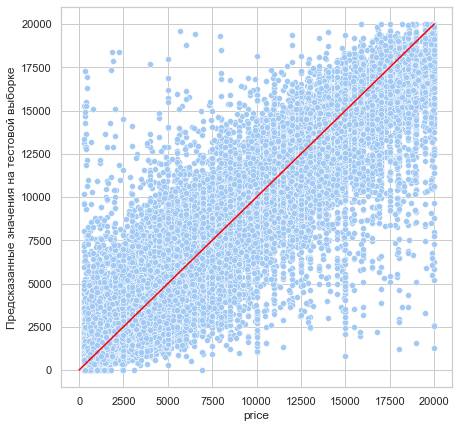

Метрика на тестовой выборке 1510.7484


name  train_time  inference_time    rmse_test   rmse_train  \
0         linear    2.974871        0.840189  2660.665996  2624.533065   
1  LGBM_easy_lim    6.238130        0.539196  1510.748437  1089.115344   

   hyper_time  
0        2040  
1        1030

In [80]:
lgb_model = lgb.LGBMRegressor(**best_lgbm_easy_params)
res = test_model('LGBM_easy_lim', lgb_model, train_f, train_t, test_f, test_t, set_target_limits=True, hyper_time=hyper_time)
result = result.append(res, ignore_index=True).drop_duplicates()
display(result)

Видим, что модель обучается довольно долго.

Метрика сильно лучше, чем в случае линейной модели.

А сейчас посмотрим на важность фичей. Сначала - встроенная функция. Посмотрим сразу на два варианта важностей:
“split” - result contains numbers of times the feature is used in a model
“gain” - result contains total gains of splits which use the feature

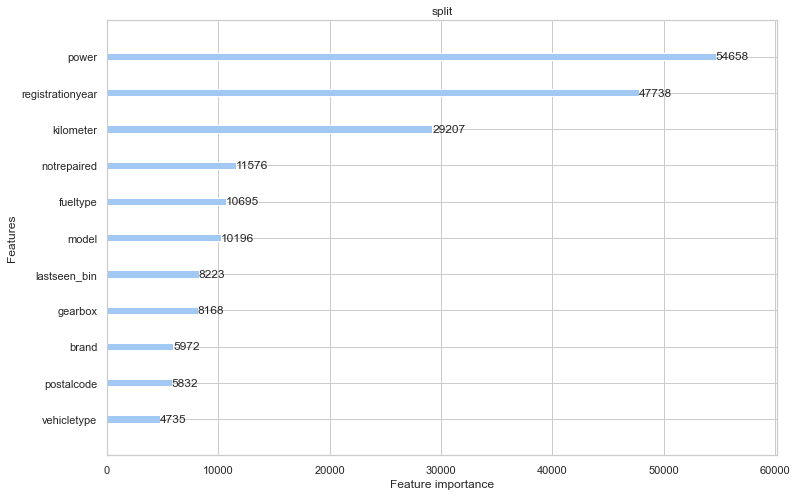

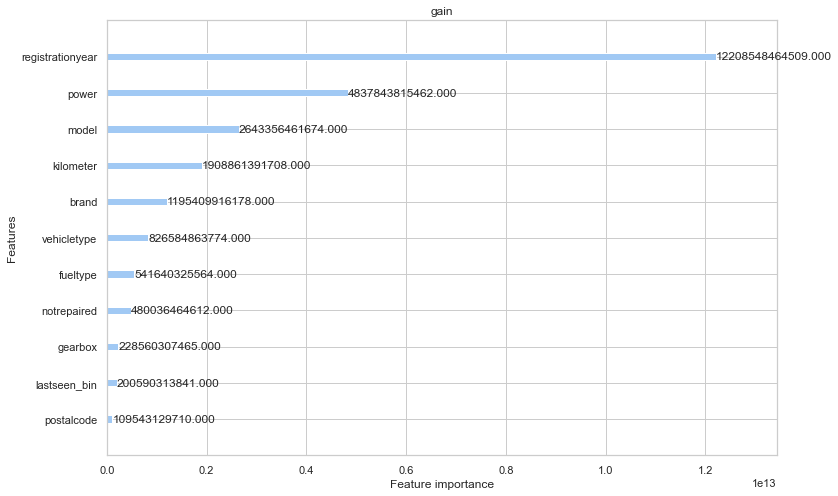

In [81]:
for imp in ['split', 'gain']:
    lgb.plot_importance(lgb_model, importance_type=imp, title=imp);

Посмотрим еще на важности, определенные классическим способом - пермутацией. Проверять будем на тестовой выборке.

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.002345192324200701, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002345192324200701
[LightGBM] [Warning] lambda_l2 is set=1.6854008330092858, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6854008330092858
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
CPU times: total: 1h 13min 8s
Wall time: 3min 56s


[Text(0.5, 0, 'Значимость признака'),
 Text(0, 0.5, 'Признак'),
 Text(0.5, 1.0, 'Значимость признаков')]

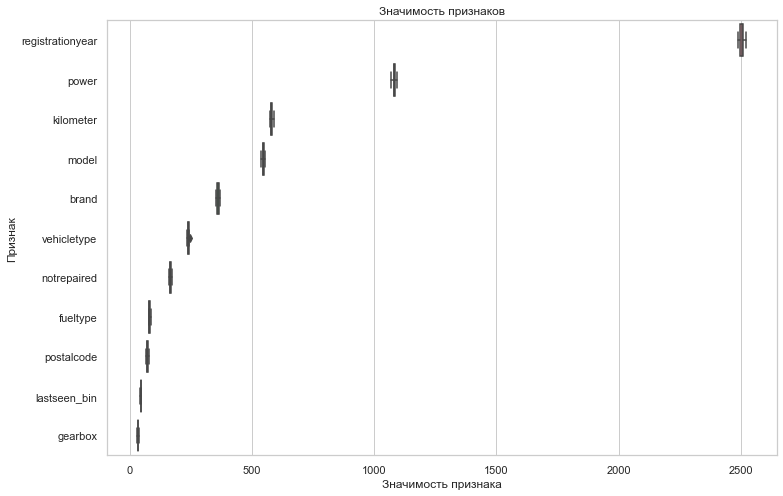

In [82]:
%%time
metr = 'neg_root_mean_squared_error'
lgb_model.fit(train_f, train_t)
a = inspection.permutation_importance(
    lgb_model,
    test_f, test_t,
    scoring=[metr],
    n_repeats=feature_importance_n_repeats if is_final else 2,
    n_jobs=1,
    random_state=random_state)
b = pd.DataFrame(a[metr]['importances'])
b['mean'] = b.mean(axis=1)
b['feature_name'] = df[cat_cols + num_cols].columns
b = b.melt(id_vars=['feature_name', 'mean']).sort_values(by='mean', ascending=False)
ax = sns.boxplot(data=b, y='feature_name', x='value')
ax.set(xlabel='Значимость признака', ylabel='Признак',
       title='Значимость признаков');

Все три картинки немного разные. Но сразу видно, какие признаки наиболее важны, а какие дают минорный прирост.

В то же время, полезность всех признаков положительная, то есть отбрасывать их было бы неверно.

### Lightgbm (hard)

Встроенная интеграция с оптуной не вызывает у меня доверия, поэтому надо бы сделать все по-честному.

Еще есть идея попробовать Generalized Linear Mixed Model Encoder https://contrib.scikit-learn.org/category_encoders/glmm.html - это аналог таргет энкодера, который вроде как выдает очень хорошие результаты, см., например, целую научную работу https://osf.io/356ed/download

А главное - он очень легко реализуется в коде!

В идеале бы добавить его в пайплайн, но придется писать обертку для этого трансформера, чтобы до самго lgbm добрался датафрейм, а не массив np, чтобы, в свою очередь, lgbm смог использовать категориальные признаки нативно.

In [83]:
df_lgbm = pd.DataFrame()
cat_cols = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired', 'lastseen_bin']
for c in cat_cols:
    df_lgbm[c] = df[c].astype('category')
num_cols = ['postalcode', 'registrationyear', 'power', 'kilometer', 'c1', 'c2']
for c in num_cols:
    df_lgbm[c] = df[c]

df_lgbm['sample'] = df['sample']
df_lgbm['price'] = df['price']
train_f = df_lgbm[df_lgbm['sample'] == 'train'].drop(columns=['price', 'sample'])
test_f = df_lgbm[df_lgbm['sample'] == 'test'].drop(columns=['price', 'sample'])
train_t = df_lgbm[df_lgbm['sample'] == 'train']['price'].drop(columns=['sample'])
test_t = df_lgbm[df_lgbm['sample'] == 'test']['price'].drop(columns=['sample'])

glmm_encoder = category_encoders.glmm.GLMMEncoder(binomial_target=False)
glmm_encoder.fit(train_f['postalcode'].astype('object'), train_t)
train_f['postalcode'] = glmm_encoder.transform(train_f['postalcode'].astype('object'))
test_f['postalcode'] = glmm_encoder.transform(test_f['postalcode'].astype('object'))

print('before', number_test_lines_before)
print('after', len(test_f))

before 83595
after 83595


Использованные гайды по гиперпараметрам:
[neptune.ai](https://neptune.ai/blog/lightgbm-parameters-guide)
[towardsdatascience](https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5)

In [84]:
%%time
param_distributions = {
    'objective': optuna.distributions.CategoricalDistribution(["rmse"]),
    'metric': optuna.distributions.CategoricalDistribution(["rmse"]),
    'random_state': optuna.distributions.CategoricalDistribution([random_state]),
    'n_jobs': optuna.distributions.CategoricalDistribution([-1]),
    "subsample_freq": optuna.distributions.CategoricalDistribution([1]),
    'verbose': optuna.distributions.CategoricalDistribution([-100]),
    "n_estimators": optuna.distributions.IntUniformDistribution(500, 1000),
    #"early_stopping_rounds": optuna.distributions.IntUniformDistribution(900, 999),
    "learning_rate": optuna.distributions.LogUniformDistribution(0.01, 0.3),
    "num_leaves": optuna.distributions.IntLogUniformDistribution(20, 300),
    "max_depth": optuna.distributions.IntUniformDistribution(3, 12),
    "min_child_samples": optuna.distributions.IntLogUniformDistribution(10, 100),
    "reg_alpha": optuna.distributions.LogUniformDistribution(1e-2, 100),
    "reg_lambda": optuna.distributions.LogUniformDistribution(1e-2, 100),
    "min_split_gain": optuna.distributions.UniformDistribution(0, 15),
    "subsample": optuna.distributions.UniformDistribution(0.4, 1),
    "colsample_bytree": optuna.distributions.UniformDistribution(0.4, 1),
    }

lgb_model_full = lgb.LGBMRegressor()

optuna_search = optuna.integration.OptunaSearchCV(
    lgb_model_full,
    param_distributions,
    cv=4,
    n_trials=None,
    timeout=2*timeout if is_final else timeout_small,
    random_state=random_state,
    scoring='neg_root_mean_squared_error',
    #n_jobs=1,
    refit=False,
    verbose=0
    )

hyper_start = time.time()
optuna_search.fit(train_f, train_t, callbacks=[lgb.log_evaluation(period=0)], categorical_feature='auto')
hyper_time = time.time() - hyper_start

# study = optuna_search.study_
# fig_list = [
#         optuna.visualization.plot_optimization_history(study),
#         optuna.visualization.plot_param_importances(study),
#     ]
# for fig in fig_list:
#     fig.update_layout(width=1000)
#     fig.show()

print("Количество запусков: {}".format(len(optuna_search.study_.trials)))
print("Лучший результат:")
trial = optuna_search.study_.best_trial
print("  метрика: {}".format(trial.value))
parameters = optuna_search.best_params_
print(parameters)

Количество запусков: 186
Лучший результат:
  метрика: -1509.2926300644672
{'objective': 'rmse', 'metric': 'rmse', 'random_state': 2077, 'n_jobs': -1, 'subsample_freq': 1, 'verbose': -100, 'n_estimators': 950, 'learning_rate': 0.05844150986810991, 'num_leaves': 289, 'max_depth': 11, 'min_child_samples': 10, 'reg_alpha': 0.7306941927275239, 'reg_lambda': 1.1211840342259007, 'min_split_gain': 0.31431236524428696, 'subsample': 0.9749809339838829, 'colsample_bytree': 0.627051185888889}
CPU times: total: 19h 34min 48s
Wall time: 1h 11s


In [85]:
best_lgbm_full_params = {'objective': 'rmse', 'metric': 'rmse', 'random_state': 2077, 'n_jobs': -1, 'subsample_freq': 1, 'verbose': -100, 'n_estimators': 950, 'learning_rate': 0.05844150986810991, 'num_leaves': 289, 'max_depth': 11, 'min_child_samples': 10, 'reg_alpha': 0.7306941927275239, 'reg_lambda': 1.1211840342259007, 'min_split_gain': 0.31431236524428696, 'subsample': 0.9749809339838829, 'colsample_bytree': 0.627051185888889}
if is_final: best_lgbm_full_params = optuna_search.best_params_

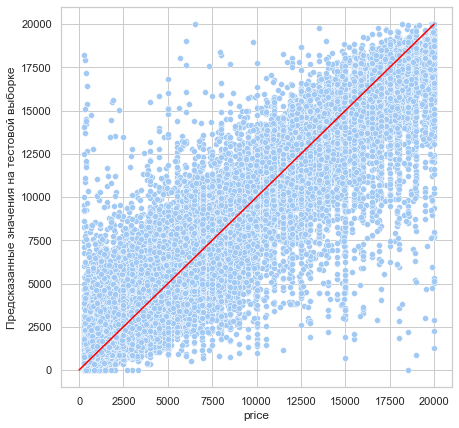

Метрика на тестовой выборке 1498.9167


name  train_time  inference_time    rmse_test   rmse_train  \
0         linear    2.974871        0.840189  2660.665996  2624.533065   
1  LGBM_easy_lim    6.238130        0.539196  1510.748437  1089.115344   
2  LGBM_full_lim    6.444438        0.806303  1498.916704   992.289439   

   hyper_time  
0        2040  
1        1030  
2        3611

In [86]:
lgb_model_full = lgb.LGBMRegressor(**best_lgbm_full_params)
res = test_model('LGBM_full_lim', lgb_model_full, train_f, train_t, test_f, test_t, set_target_limits=True, hyper_time=hyper_time)
result = result.append(res, ignore_index=True).drop_duplicates()
display(result)

Результат лучше, чем был!

Посмотрим на важности фичей. Пермутация кажется мне наиболее наглядной.

CPU times: total: 2h 3min 52s
Wall time: 6min 56s


[Text(0.5, 0, 'Значимость признака'),
 Text(0, 0.5, 'Признак'),
 Text(0.5, 1.0, 'Значимость признаков')]

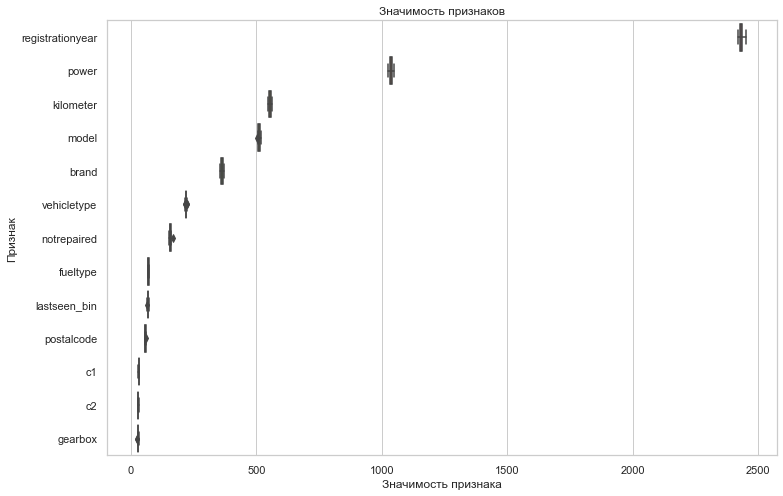

In [87]:
%%time
X = train_f
y = train_t
metr = 'neg_root_mean_squared_error'
lgb_model_full.fit(train_f, train_t)
a = inspection.permutation_importance(
    lgb_model_full,
    test_f, test_t,
    scoring=[metr],
    n_repeats=feature_importance_n_repeats if is_final else 2,
    n_jobs=1,
    random_state=random_state)
b = pd.DataFrame(a[metr]['importances'])
b['mean'] = b.mean(axis=1)
b['feature_name'] = df[cat_cols + num_cols].columns
b = b.melt(id_vars=['feature_name', 'mean']).sort_values(by='mean', ascending=False)
ax = sns.boxplot(data=b, y='feature_name', x='value')
ax.set(xlabel='Значимость признака', ylabel='Признак',
       title='Значимость признаков');

По сути все то же самое, что и выше было.

### XGBoost

xgb для меня является дефолтной библиотекой - работает быстрее катбуста и точнее lgbm.

Отметим, что xgb не умеет работать с категориальными переменными - ему на вход, как и линейной регрессии, надо подавать чисто числовую таблицу. Хотя вроде там есть какая-то экспериментальная функция для этого... но зачем, если у нас есть пайплайны.

В этот раз попробуем не городить кучу оберток, а сделать все встроенными средствами.

In [88]:
cat_cols = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired', 'postalcode']
num_cols = ['registrationyear', 'power', 'kilometer', 'lastseen_bin', 'c1', 'c2']

encoder_params = dict(
    handle_missing='return_nan',
    handle_unknown='return_nan',
    return_df=False
)

cat_cols_list = [
    ('vehicletype', category_encoders.one_hot.OneHotEncoder(**encoder_params), 'vehicletype'),
    ('gearbox', category_encoders.one_hot.OneHotEncoder(**encoder_params), 'gearbox'),
    ('model', category_encoders.target_encoder.TargetEncoder(min_samples_leaf=3, smoothing=0.05, **encoder_params), 'model'),
    ('fueltype',category_encoders.one_hot.OneHotEncoder(**encoder_params), 'fueltype'),
    #('brand', category_encoders.glmm.GLMMEncoder(**encoder_params), 'brand'),
    ('brand', category_encoders.one_hot.OneHotEncoder(**encoder_params), 'brand'),
    ('notrepaired', category_encoders.one_hot.OneHotEncoder(**encoder_params), 'notrepaired'),
    ('postalcode', category_encoders.glmm.GLMMEncoder(**encoder_params), 'postalcode'),
]
cat_cols_transformer = compose.ColumnTransformer(cat_cols_list)

num_cols_list = [(col_name, preprocessing.StandardScaler(), [col_name]) for col_name in num_cols]
num_cols_transformer = compose.ColumnTransformer(num_cols_list)

data_preprocessing = pipeline.FeatureUnion([
    ('num_line', num_cols_transformer),
    ('cat_line', cat_cols_transformer),
    ])

gpu_params = {
#    'tree_method':'gpu_hist'
}

pipe = pipeline.Pipeline([
    ('data', data_preprocessing),
    ('estimator', estimator_wrapper(xgb.XGBRegressor(**gpu_params), lim=False))
    ])

In [89]:
k = 2

param_distributions = {
    'estimator__'*k + 'n_estimators': optuna.distributions.IntUniformDistribution(150, 300),
    'estimator__'*k + 'max_depth': optuna.distributions.IntUniformDistribution(3, 7),
    'estimator__'*k + 'learning_rate': optuna.distributions.LogUniformDistribution(5e-2, 5e-1),
    'estimator__'*k + 'min_child_weight': optuna.distributions.LogUniformDistribution(2e-0, 5e2),
    'estimator__'*k + 'subsample': optuna.distributions.UniformDistribution(0.6, 1),
    'estimator__'*k + 'reg_lambda': optuna.distributions.LogUniformDistribution(2e-2, 1e3),
    'estimator__'*k + 'reg_alpha': optuna.distributions.LogUniformDistribution(1e-7, 1e-4),
    'estimator__'*k + 'colsample_bytree': optuna.distributions.UniformDistribution(0.8, 1),
    'estimator__'*k + 'colsample_bylevel': optuna.distributions.UniformDistribution(0.7, 1),
    'estimator__'*k + 'colsample_bynode': optuna.distributions.UniformDistribution(0.9, 1),
    'estimator__'*k + 'eval_metric': optuna.distributions.CategoricalDistribution(["rmse"]),
    }

In [90]:
%%time
optuna_search = optuna.integration.OptunaSearchCV(
        pipe,
        param_distributions,
        cv=4,
        timeout=2*timeout if is_final else timeout_small,
        n_trials=None,
        random_state=random_state,
        scoring='neg_root_mean_squared_error',
        n_jobs=2,
        refit=False,
        verbose=0
        )

hyper_start = time.time()
optuna_search.fit(df[df['sample'] == 'train'], df[df['sample'] == 'train']['price'])
hyper_time = time.time() - hyper_start

# study = optuna_search.study_
# fig_list = [
#         optuna.visualization.plot_optimization_history(study),
#         optuna.visualization.plot_param_importances(study),
#     ]
# for fig in fig_list:
#     fig.update_layout(width=1000)
#     fig.show()

print("Количество запусков: {}".format(len(optuna_search.study_.trials)))
print("Лучший результат:")
trial = optuna_search.study_.best_trial
print("  метрика: {}".format(trial.value))
parameters = optuna_search.best_params_
print(parameters)

Количество запусков: 105
Лучший результат:
  метрика: -1601.9835510253906
{'estimator__estimator__n_estimators': 278, 'estimator__estimator__max_depth': 7, 'estimator__estimator__learning_rate': 0.16230088838135814, 'estimator__estimator__min_child_weight': 2.025289913083904, 'estimator__estimator__subsample': 0.7006131176883361, 'estimator__estimator__reg_lambda': 8.574194720012343, 'estimator__estimator__reg_alpha': 5.756715952647511e-06, 'estimator__estimator__colsample_bytree': 0.9913276556516516, 'estimator__estimator__colsample_bylevel': 0.8410510303360512, 'estimator__estimator__colsample_bynode': 0.9980421736208006, 'estimator__estimator__eval_metric': 'rmse'}
CPU times: total: 18h 44min 29s
Wall time: 1h 44s


In [91]:
best_xgb_params = {'estimator__estimator__n_estimators': 284, 'estimator__estimator__max_depth': 7, 'estimator__estimator__learning_rate': 0.15189915225380182, 'estimator__estimator__min_child_weight': 3.323030225445879, 'estimator__estimator__subsample': 0.9081395874771117, 'estimator__estimator__reg_lambda': 0.031405558304326286, 'estimator__estimator__reg_alpha': 1.9304524477648106e-07, 'estimator__estimator__colsample_bytree': 0.8951419506721674, 'estimator__estimator__colsample_bylevel': 0.7827619177113687, 'estimator__estimator__colsample_bynode': 0.962027360924159, 'estimator__estimator__eval_metric': 'rmse'}
if is_final: best_xgb_params = optuna_search.best_params_

In [92]:
train_f = df[df['sample'] == 'train'].drop(columns=['price', 'sample'])
test_f = df[df['sample'] == 'test'].drop(columns=['price', 'sample'])
train_t = df[df['sample'] == 'train']['price'].drop(columns=['sample'])
test_t = df[df['sample'] == 'test']['price'].drop(columns=['sample'])
print('before', number_test_lines_before)
print('after', len(test_f))

before 83595
after 83595


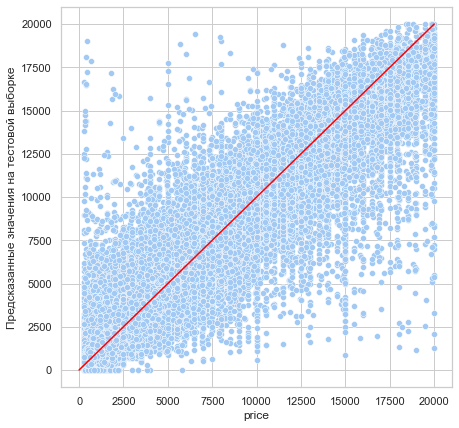

Метрика на тестовой выборке 1597.0437


name  train_time  inference_time    rmse_test   rmse_train  \
0         linear    2.974871        0.840189  2660.665996  2624.533065   
1  LGBM_easy_lim    6.238130        0.539196  1510.748437  1089.115344   
2  LGBM_full_lim    6.444438        0.806303  1498.916704   992.289439   
3   XGB_full_lim   18.293848        0.267106  1597.043701  1417.240234   

   hyper_time  
0        2040  
1        1030  
2        3611  
3        3644

In [93]:
pipe.set_params(**best_xgb_params)
res = test_model('XGB_full_lim', pipe, train_f, train_t, test_f, test_t, set_target_limits=True, hyper_time=hyper_time)
result = result.append(res, ignore_index=True).drop_duplicates()
display(result)

Результат как-то не впечатляет.

Посмотрим на важности признаков. Так как у нас тут пайплайн, встроенная в xgboost важность фичей нам не поможет - на вход подаются закодированные признаки.

Поэтому используем старую добрую пермутацию.

CPU times: total: 33min 45s
Wall time: 2min 41s


[Text(0.5, 0, 'Значимость признака'),
 Text(0, 0.5, 'Признак'),
 Text(0.5, 1.0, 'Значимость признаков для XGBoost')]

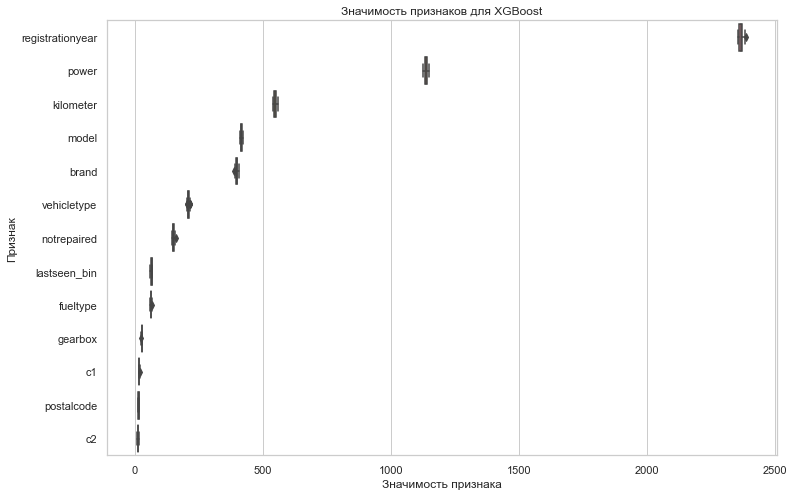

In [94]:
%%time
X = df[df['sample'] == 'train'][cat_cols + num_cols]
y = df[df['sample'] == 'train']['price']
X_test = df[df['sample'] == 'test'][cat_cols + num_cols]
y_test = df[df['sample'] == 'test']['price']
metr = 'neg_root_mean_squared_error'
pipe.fit(X, y)
a = inspection.permutation_importance(
    pipe,
    X_test, y_test,
    scoring=[metr],
    n_repeats=feature_importance_n_repeats if is_final else 2,
    n_jobs=1, random_state=random_state)
b = pd.DataFrame(a[metr]['importances'])
b['mean'] = b.mean(axis=1)
b['feature_name'] = df[cat_cols + num_cols].columns
b = b.melt(id_vars=['feature_name', 'mean']).sort_values(by='mean', ascending=False)
ax = sns.boxplot(data=b, y='feature_name', x='value')
ax.set(xlabel='Значимость признака', ylabel='Признак',
       title='Значимость признаков для XGBoost');

А вот эти важности мне уже больше нравятся, потому что соответствуют интуитивному пониманию ситуации.

Кроме того, тут сразу видно, что наши координаты практически бесполезны - GLMMEncoder отлично кодирует postalcode.

### Catboost

Катбуст по моему опыту самый точный, но безумно медленный.

Кроме того, он плохо совместим с интерфейсами sklearn и optuna, поэтому придется городить все вручную.

Сначала надо сделать объект - обучающий пул. В нем же указано, какие столбцы категориальные.

In [95]:
cat_cols = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired', 'postalcode', 'lastseen_bin']
num_cols = ['registrationyear', 'power', 'kilometer']

df_catboost = df.copy()
for c in cat_cols:
    df_catboost[c] = df_catboost[c].fillna('nan')

train_pool = Pool(
    df_catboost[df_catboost['sample'] == 'train'][cat_cols+num_cols],
    df_catboost[df_catboost['sample'] == 'train']['price'],
    cat_features=cat_cols)
train_pool.set_feature_names(cat_cols+num_cols)

test_pool = Pool(
    df_catboost[df_catboost['sample'] == 'test'][cat_cols+num_cols],
    df_catboost[df_catboost['sample'] == 'test']['price'],
    cat_features=cat_cols)
test_pool.set_feature_names(cat_cols+num_cols);

Дальше делаем функцию objective для оптуны.

К сожалению, встроенная функция cv для катбуста при работе на GPU выдает ошибку, поэтому кросс-валидация написана вручную.

In [96]:
def objective(trial):

    global train_pool
    global df_catboost

    params = {
        'n_estimators': trial.suggest_int("n_estimators", 400, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 5e-1, log=True),
        'max_depth': trial.suggest_int("max_depth", 2, 6),
        #'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 2., 4),
        'bagging_temperature': trial.suggest_float("bagging_temperature", 0.1, 1.9),
        #'random_strength': trial.suggest_float("random_strength", 0.9, 1.4),

        'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 1, 20),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'random_state': trial.suggest_categorical('random_state', [random_state]),
        "eval_metric": trial.suggest_categorical('eval_metric', ["RMSE"]),
        "loss_function": trial.suggest_categorical('loss_function', ['RMSE']),
        'silent': trial.suggest_categorical('silent', [True]),
        #'logging_level': trial.suggest_categorical('logging_level', [None]),
        'task_type': trial.suggest_categorical('task_type', ['GPU']),
        'devices': trial.suggest_categorical('devices', ['0:1']),
        }

    n_splits = 2
    cv_folds = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    scores = []
    for i, (mini_train, mini_valid) in enumerate(cv_folds.split(
            df_catboost[df_catboost['sample'] == 'train'],
            df_catboost[df_catboost['sample'] == 'train']['price']
    )):
        cat_reg = cat.CatBoostRegressor(**params)
        cat_reg.fit(train_pool.slice(mini_train))
        s = cat_reg.eval_metrics(train_pool.slice(mini_valid), 'RMSE')['RMSE'][-1]
        scores.append(s)

    return np.mean(scores)

In [97]:
%%time
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction="minimize")

hyper_start = time.time()
study.optimize(objective,
               n_trials=None,
               timeout=timeout if is_final else timeout_small,
               )
hyper_time = time.time() - hyper_start

# fig_list = [
#         optuna.visualization.plot_optimization_history(study),
#         optuna.visualization.plot_param_importances(study),
#     ]
# for fig in fig_list:
#     fig.update_layout(width=1000)
#     fig.show()

print("Количество запусков: {}".format(len(study.trials)))

print("Лучший результат:")
trial = study.best_trial
print("  Метрика: {}".format(trial.value))

trial = study.best_trial
parameters = trial.params
print('Оптимальные параметры:', parameters)

Количество запусков: 77
Лучший результат:
  Метрика: 1625.810310165695
Оптимальные параметры: {'n_estimators': 900, 'learning_rate': 0.19832907908902297, 'max_depth': 6, 'l2_leaf_reg': 2.7403609250772383, 'bagging_temperature': 0.4896485215477466, 'min_data_in_leaf': 6, 'grow_policy': 'Lossguide', 'random_state': 2077, 'eval_metric': 'RMSE', 'loss_function': 'RMSE', 'silent': True, 'task_type': 'GPU', 'devices': '0:1'}
CPU times: total: 55min 48s
Wall time: 30min 6s


In [98]:
best_cat_params = {'n_estimators': 914, 'learning_rate': 0.19612810560847013, 'max_depth': 6, 'l2_leaf_reg': 2.1420929193020255, 'bagging_temperature': 0.6646591796869662, 'min_data_in_leaf': 6, 'grow_policy': 'SymmetricTree', 'random_state': 2077, 'eval_metric': 'RMSE', 'loss_function': 'RMSE', 'silent': True, 'task_type': 'GPU', 'devices': '0:1'}
if is_final: best_cat_params = parameters

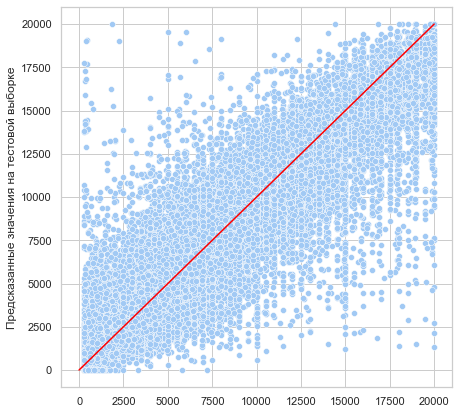

Метрика на тестовой выборке 1584.1036


name  train_time  inference_time    rmse_test   rmse_train  \
0         linear    2.974871        0.840189  2660.665996  2624.533065   
1  LGBM_easy_lim    6.238130        0.539196  1510.748437  1089.115344   
2  LGBM_full_lim    6.444438        0.806303  1498.916704   992.289439   
3   XGB_full_lim   18.293848        0.267106  1597.043701  1417.240234   
4        cat_lim   12.882939        0.061746  1584.103643  1430.538699   

   hyper_time  
0        2040  
1        1030  
2        3611  
3        3644  
4        1806

In [99]:
cat_reg = cat.CatBoostRegressor(**best_cat_params)
res = test_model('cat_lim', cat_reg, is_cat=True, train_pool=train_pool, test_pool=test_pool, hyper_time=hyper_time)
result = result.append(res, ignore_index=True).drop_duplicates()
display(result)

По традиции посмотрим на важность фичей.

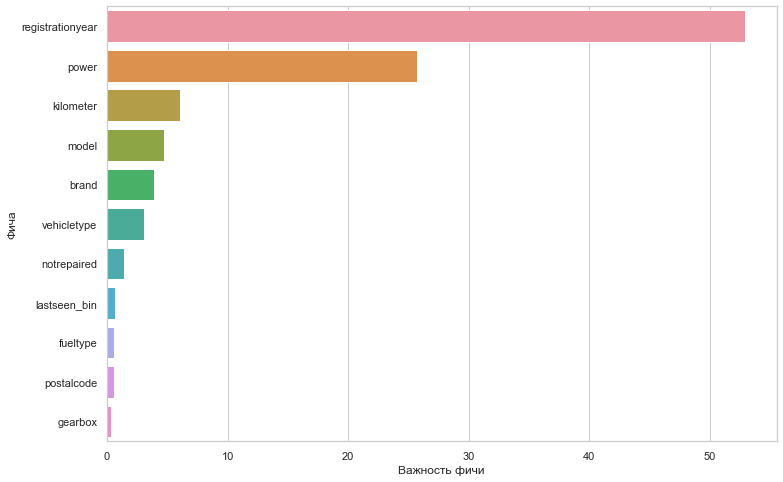

In [125]:
cat_reg.get_feature_importance(test_pool)

tmp = pd.DataFrame({'Важность фичи': cat_reg.get_feature_importance(train_pool),
              'Фича': train_pool.get_feature_names()}).sort_values(by=['Важность фичи'],
                                                           ascending=False).reset_index(drop=True)

sns.barplot(data=tmp, x='Важность фичи', y='Фича', orient = 'h');

### Нейросеть

Рискнем?

Сначала надо сделать даталоадер. В частности, из обучающей выборки надо выделить еще и валидационную.

In [101]:
df = df.reset_index(drop=True)
valid_split = 0.2
batch_size = 512
train_valid_ind = np.array(df[df['sample'] == 'train'].index)
test_indices = np.array(df[df['sample'] == 'test'].index)
np.random.shuffle(train_valid_ind)
split = int(np.floor(valid_split * len(train_valid_ind)))
train_indices, val_indices = train_valid_ind[split:], train_valid_ind[:split]

Теперь нам надо превратить датафрейм в np массивы. Сделаем пайплайн (он будет в значительной степени повторять пайплайн для xgb.

In [102]:
cat_cols = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired', 'postalcode']
num_cols = ['registrationyear', 'power', 'kilometer', 'lastseen_bin']

encoder_params = dict(
    handle_missing='indicator',
    handle_unknown='indicator',
    return_df=False
)

cat_cols_list = [
    ('vehicletype', category_encoders.one_hot.OneHotEncoder(**encoder_params), 'vehicletype'),
    ('gearbox', category_encoders.one_hot.OneHotEncoder(**encoder_params), 'gearbox'),
    #('model', category_encoders.target_encoder.TargetEncoder(min_samples_leaf=3, smoothing=0.05, **encoder_params), 'model'),
    ('model', category_encoders.one_hot.OneHotEncoder(**encoder_params), 'model'),
    ('fueltype',category_encoders.one_hot.OneHotEncoder(**encoder_params), 'fueltype'),
    #('brand', category_encoders.glmm.GLMMEncoder(**encoder_params), 'brand'),
    ('brand', category_encoders.one_hot.OneHotEncoder(**encoder_params), 'brand'),
    ('notrepaired', category_encoders.one_hot.OneHotEncoder(**encoder_params), 'notrepaired'),
    ('postalcode', category_encoders.glmm.GLMMEncoder(**encoder_params), 'postalcode'),
]
cat_cols_transformer = compose.ColumnTransformer(cat_cols_list)

num_cols_list = [(col_name, impute.SimpleImputer(), [col_name]) for col_name in num_cols]
num_cols_transformer = compose.ColumnTransformer(num_cols_list)

numeric_pipeline = pipeline.Pipeline([
    ('num_trans', num_cols_transformer),
    ('scaler', preprocessing.StandardScaler())
    ])

data_preprocessing = pipeline.FeatureUnion([
    ('num_line', numeric_pipeline),
    ('cat_line', cat_cols_transformer),
    ])

In [103]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        res = (self.X[index], self.y[index])
        return res

Обучим наш пайплайн предобработки на тренировочной выборке, а потом применим ко всему датафрейму.

In [104]:
data_preprocessing.fit(df[df['sample'] == 'train'], df[df['sample'] == 'train']['price'])
dataset = CustomDataset(data_preprocessing.transform(df), df['price'])

Сделаем три лоадера.

In [105]:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=train_sampler,
                                           #num_workers=2
                                         )
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=val_sampler,
                                           #num_workers=2
                                         )

test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=test_sampler,
                                           #num_workers=2
                                         )

Проверим, что все работает.

In [106]:
for i, (x,y) in enumerate(train_loader):
    print(x.shape, y.shape)
    print(x)
    print(y)
    break

torch.Size([512, 317]) torch.Size([512])
tensor([[-1.3790e+00,  5.4280e-01,  5.7980e-01,  ...,  0.0000e+00,
          0.0000e+00,  4.7624e+04],
        [-2.0072e+00,  1.4395e+00,  5.7980e-01,  ...,  1.0000e+00,
          0.0000e+00,  8.8131e+04],
        [ 8.1989e-01, -1.1283e+00,  5.7980e-01,  ...,  0.0000e+00,
          0.0000e+00,  5.4290e+04],
        ...,
        [-4.3661e-01,  9.4733e-13,  5.7980e-01,  ...,  0.0000e+00,
          0.0000e+00,  2.7616e+04],
        [-9.0779e-01, -1.4137e+00,  5.7980e-01,  ...,  0.0000e+00,
          0.0000e+00,  4.9637e+04],
        [ 1.7623e+00, -7.6150e-01, -2.6467e+00,  ...,  0.0000e+00,
          0.0000e+00,  7.4078e+04]], dtype=torch.float64)
tensor([ 2698,   500,  1900,   850,   500, 13100,  2999,  2350,  3399,  1999,
         9500,  4600,  3500,  1200, 14990,  1599,  3450,  2950,  1250,  2000,
         2000,  6999,  5250,  3000,  3100,  4200,   300,  2666, 16450, 14650,
         6900,   600, 16700,  3500,   750,  4790,  2500,   699,  7999,  

Сделаем функцию для рисования кривых обучения.

In [107]:
def plot_learning_curves(history, metric_name='Metric'):
    tmp = pd.DataFrame(history).reset_index().rename(columns={'index':'epoch'})
    fig = plt.figure(figsize=(6, 9))
    fig.patch.set_facecolor('xkcd:white')
    ax = plt.subplot(3, 1, 1)
    plt.plot(tmp['epoch'], tmp['train_metric'], label='train')
    plt.plot(tmp['epoch'], tmp['val_metric'], label='val')
    plt.legend()
    plt.xlabel('epoch')
    ax.set_title(metric_name)

    ax = plt.subplot(3, 1, 2)
    plt.plot(tmp['epoch'], tmp['train_loss'], label='train')
    plt.plot(tmp['epoch'], tmp['val_loss'], label='val')
    plt.legend()
    plt.xlabel('epoch')
    ax.set_title("Loss")

    ax = plt.subplot(3, 1, 3)
    plt.plot(tmp['epoch'], tmp['LR'], label='LR')
    plt.xlabel('epoch')
    ax.set_yscale('log')
    ax.set_title("Learning rate (first parameters set)")
    fig.tight_layout()

Дальше сделаем функцию обучения модели. Много кода, зато результат красивый.

In [108]:
def train_model(model, dataloaders, loss, optimizer,
                num_epochs=2, target_metric=None, scheduler=None, device='find', set_best_params=True, visual=False):
    if device == 'find': device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    history = {}
    history['train_loss'] = []
    history['val_loss'] = []
    history['train_metric'] = []
    history['val_metric'] = []
    history['LR'] = []

    since = time.time()
    model.to(device)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_metric = False
    best_iter = False

    for epoch in range(num_epochs):
        best_iter = False
        learning_rate = optimizer.param_groups[0]["lr"]
        history['LR'].append(learning_rate)
        print(f'Epoch {epoch+1}/{num_epochs}, LR: {learning_rate:.1e}, ', end='')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            gt = []
            predictions = []
            losses = []
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
#           running_corrects = 0
            running_samples = 0

            # Iterate over data.
            for idx, (inputs, labels) in enumerate(dataloaders[phase]):
                gt.extend(labels.cpu().detach().numpy())
                running_samples += len(labels)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.float()) ## CHANGED
                    predictions.extend(outputs.cpu().detach().numpy().flatten())
                    loss_value = loss(outputs.flatten(), labels.float())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                losses.append(loss_value.item())

            if phase == 'train' and scheduler:
                scheduler.step()

            epoch_loss = sum(losses) / len(gt)
            epoch_metric = target_metric(gt, predictions)

            print(f'{phase} Loss: {epoch_loss:.4f} metric: {epoch_metric:.4f}, ', end='')

            if phase == 'val' and best_metric == False:
                best_metric = epoch_metric

            # deep copy the model
            if phase == 'val' and epoch_metric < best_metric:
                best_iter = True
                best_metric = epoch_metric
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_metric'].append(epoch_metric)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_metric'].append(epoch_metric)

        time_elapsed = time.time() - since
        print(f'time: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s' + ' [best]'*best_iter)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val metric: {best_metric}')

    # load best model weights
    if set_best_params:
        print('Загружаем лучшие параметры')
        model.load_state_dict(best_model_wts)

    if visual:
        try:
            plot_learning_curves(history)
        except Exception as e:
            print('error during plot:\n', e)

    model.to('cpu')
    return history

Почему бы не запустить это все на видеокарте? По идее какого-то значимого прироста это не даст, конечно... (измерил - прирост есть. Процентов 50)

In [109]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


А теперь делаем саму сеть. У нас много разных "мелких категорий", высок риск переобучения, поэтому вставим туда дропаут слои.

In [110]:
input_len = dataset[0][0].shape[0]
print('input_len =',input_len)
hidden_start = 256
hidden_end = 16
dropout = 0.2
nn_model = nn.Sequential(
        nn.BatchNorm1d(input_len),
        nn.Linear(input_len, hidden_start),
        nn.BatchNorm1d(hidden_start),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout),
        nn.Linear(hidden_start, hidden_start // 2),
        nn.BatchNorm1d(hidden_start // 2),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout),
        nn.Linear(hidden_start // 2, hidden_end),
        nn.BatchNorm1d(hidden_end),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout),
        nn.Linear(hidden_end, 1),
        )
nn_model.type(torch.FloatTensor)
nn_model.to(device);

input_len = 317


Задаем параметры обучения, в частности, планировщик отжига.

In [111]:
if is_final:
    step_length = 80
    step_num = 2
else:
    step_length = 11
    step_num = 2

loss = nn.MSELoss()
optimizer = optim.AdamW(nn_model.parameters(), lr=5e-1, weight_decay=1e-3)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=step_length, T_mult=1, eta_min=0.0005, last_epoch=-1)
loader = {}
loader['train'] = train_loader
loader['val'] = val_loader

Ну и само обучение.

Epoch 1/159, LR: 5.0e-01, train Loss: 12902.7688 metric: 2569.9636, val Loss: 15760.9282 metric: 2840.1357, time: 0m 5s
Epoch 2/159, LR: 5.0e-01, train Loss: 8387.4854 metric: 2071.8540, val Loss: 9080.7997 metric: 2155.9155, time: 0m 8s [best]
Epoch 3/159, LR: 5.0e-01, train Loss: 8131.4955 metric: 2039.8906, val Loss: 7889.6261 metric: 2009.4832, time: 0m 11s [best]
Epoch 4/159, LR: 5.0e-01, train Loss: 8024.2396 metric: 2026.5181, val Loss: 7667.8545 metric: 1981.0201, time: 0m 14s [best]
Epoch 5/159, LR: 5.0e-01, train Loss: 7965.7984 metric: 2019.1602, val Loss: 8057.0516 metric: 2030.7532, time: 0m 17s
Epoch 6/159, LR: 5.0e-01, train Loss: 7900.1039 metric: 2010.7919, val Loss: 8796.8666 metric: 2121.8643, time: 0m 20s
Epoch 7/159, LR: 4.9e-01, train Loss: 7893.3088 metric: 2009.9985, val Loss: 7669.9136 metric: 1981.3040, time: 0m 23s
Epoch 8/159, LR: 4.9e-01, train Loss: 7805.7248 metric: 1998.8354, val Loss: 6780.6313 metric: 1862.9036, time: 0m 26s [best]
Epoch 9/159, LR: 4.9

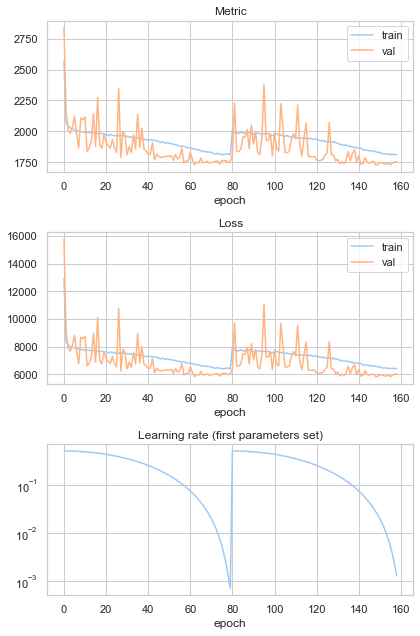

In [112]:
train_start = time.time()
history = train_model(nn_model, loader, loss, optimizer,
                      target_metric=lambda x, y: metrics.mean_squared_error(x, y, squared=False),
                      num_epochs=step_length*step_num-1, device=device, scheduler=lr_sched, visual=True)
train_time = time.time() - train_start

Отметим, что лучший результат на валидации был достигнут где-то на 70 эпохе, а все дальнейшее обучение ничего не дало.

Напишем функцию, которая по сути predict. Потому что это же нейросеть, здесь же нельзя просто в одну строчку все сделать...

In [113]:
def get_nn_result(model, loader):
    gt = []
    predictions = []
    model.eval()
    for idx, (inputs, labels) in enumerate(loader):
        gt.extend(labels.cpu().detach().numpy())
        with torch.set_grad_enabled('val' == 'train'):
            outputs = model(inputs.float())
            predictions.extend(outputs.cpu().detach().numpy().flatten())
    return gt, predictions

Ну и замеряем ключевые результаты.

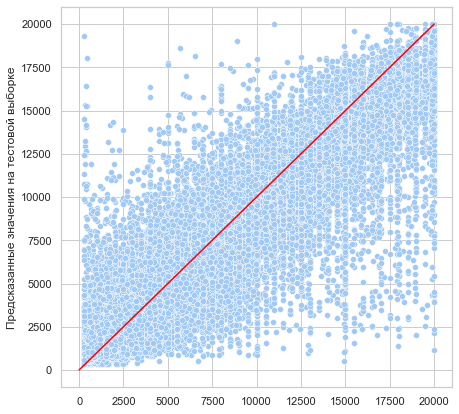

{'name': 'Neural',
 'train_time': 467.11173486709595,
 'inference_time': 0.7444169521331787,
 'rmse_test': 1706.4849,
 'rmse_train': 1604.9661}

In [114]:
lim_down = df[df['sample'] == 'train']['price'].min()
lim_up = df[df['sample'] == 'train']['price'].max()

g, p = get_nn_result(nn_model, train_loader)
p = np.clip(p, lim_down, lim_up)
rmse_train = metrics.mean_squared_error(g, p, squared=False)

inference_start = time.time()
g, p = get_nn_result(nn_model, test_loader)
p = np.clip(p, lim_down, lim_up)
inference_time = time.time() - inference_start

rmse_test = metrics.mean_squared_error(g, p, squared=False)

fig = plt.figure(figsize=(7,7))
ax = sns.scatterplot(x=g, y=p)
plt.plot([0, train_t.max()], [0, train_t.max()], color='red')
ax.set(ylabel='Предсказанные значения на тестовой выборке')
plt.show()

res = dict(
        name='Neural',
        train_time=train_time,
        inference_time=inference_time,
        rmse_test=rmse_test,
        rmse_train=rmse_train
    )
res

In [115]:
result = result.append(res, ignore_index=True).drop_duplicates()
display(result)

name  train_time  inference_time    rmse_test   rmse_train  \
0         linear    2.974871        0.840189  2660.665996  2624.533065   
1  LGBM_easy_lim    6.238130        0.539196  1510.748437  1089.115344   
2  LGBM_full_lim    6.444438        0.806303  1498.916704   992.289439   
3   XGB_full_lim   18.293848        0.267106  1597.043701  1417.240234   
4        cat_lim   12.882939        0.061746  1584.103643  1430.538699   
5         Neural  467.111735        0.744417  1706.484863  1604.966064   

   hyper_time  
0      2040.0  
1      1030.0  
2      3611.0  
3      3644.0  
4      1806.0  
5         NaN

## Анализ остатков

Видим, что лучший результат на тесте выдали модели LGBM. В то же время, результат все равно не очень хорош - ошибка более 1000 евро в случае цены до 4000, как мне кажется, уже делает модель бесполезной.

Интересно посмотреть, где наша модель чаще всего ошибается. Для этого возьмем **тестовую** выборку, предскажем цену для каждой строки и добавим предсказанную цену как отдельный столбец.

В качестве рабочей используем модель LGBM_easy, потому что у нее быстрый инференс.

In [116]:
df_lgbm = pd.DataFrame()
for c in ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired', 'lastseen_bin', 'postalcode']:
    df_lgbm[c] = df[c]
    if c == 'postalcode':
        l = 150
        good_codes = df[df['sample'] == 'train'][c].value_counts().head(l).index
        # внимание - тут используется только обучающая выборка. Никакого подглядывания!
        df_lgbm[c] = df_lgbm[c].apply(lambda x: x if x in good_codes else -1)
    df_lgbm[c] = df_lgbm[c].astype('category')
for c in ['registrationyear', 'power', 'kilometer']:
    df_lgbm[c] = df[c]

df_lgbm['sample'] = df['sample']
df_lgbm['price'] = df['price']
train_f = df_lgbm[df_lgbm['sample'] == 'train'].drop(columns=['price', 'sample'])
test_f = df_lgbm[df_lgbm['sample'] == 'test'].drop(columns=['price', 'sample'])
train_t = df_lgbm[df_lgbm['sample'] == 'train']['price'].drop(columns=['sample'])
test_t = df_lgbm[df_lgbm['sample'] == 'test']['price'].drop(columns=['sample'])

Вспомним, что сама модель у нас уже обучена, поэтому можно сразу делать предикт. Сошьем тестовую выборку и предсказания в один датафрейм, сделаем столбец с модулем ошибки предсказаний. В качестве ошибки будем использовать процент (точнее, долю) отклонения от истинной цены - мне кажется, что для пользователя это самая важная и понятная характеристика.

In [117]:
test_df = df_lgbm[df_lgbm['sample'] == 'test'].reset_index(drop=True)
test_df = test_df.join(pd.Series(lgb_model.predict(test_f), name='pred_price'))
test_df['error'] = np.abs(test_df['price'] - test_df['pred_price']) / test_df['price']
test_df = test_df.drop(columns=['sample', 'postalcode', 'pred_price'])

Посмотрим на полученное распределение.

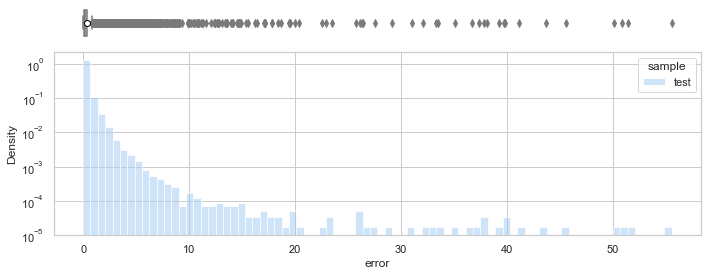

Медиана ошибки 0.18868306836808618


In [118]:
tmp = test_df.copy()
tmp['sample'] = 'test'
feature_analyze(tmp, 'error', text_out=False, logscale=True)
print('Медиана ошибки', test_df['error'].median())

Видим ряд совершенно неадекватных значений, отличающихся в 10 и более раз. Медиана ошибки менее 20%. То есть по большинству строк у нас ошибка менее 20%. Неплохо!

Сначала посмотрим на топ лучших предсказаний.

In [119]:
test_df.sort_values('error').head(8)

vehicletype gearbox   model  fueltype       brand notrepaired  \
31925        sedan  manual    golf    petrol  volkswagen          no   
81515        small  manual    polo    petrol  volkswagen         NaN   
53236  convertible  manual  escort    petrol        ford          no   
36187        sedan  manual    golf  gasoline  volkswagen          no   
80882        small  manual      ka    petrol        ford         yes   
30825        sedan    auto      a3  gasoline        audi          no   
68788        sedan  manual    golf    petrol  volkswagen          no   
76503        small  manual  cooper    petrol        mini          no   

      lastseen_bin  registrationyear  power  kilometer  price     error  
31925         True            2004.0   75.0     150000   3500  0.000008  
81515        False            2002.0   54.0     150000   1990  0.000010  
53236         True            1997.0   90.0     150000   1199  0.000014  
36187        False            2012.0  140.0      50000  15500  0.000019  
80882        False            2000.0   60.0     150000    500  0.000024  
30825         True            2011.0  140.0      80000  15499  0.000027  
68788         True            2000.0  101.0     150000   1850  0.000037  
76503         True            2010.0  184.0      30000  15000  0.000043

Видим, что здесь практически нет пропусков.

Интересно, что наш столбец lastseen_bin (хотим ли мы быстро продать машину) реально работает - в топовых предсказаниях тру и фолс встречаются поровну.

А теперь худшие предсказания.

In [120]:
test_df.sort_values('error').tail(8)

vehicletype gearbox    model  fueltype    brand notrepaired  \
42443       wagon    auto   laguna  gasoline  renault          no   
26699       sedan  manual      1er    petrol      bmw          no   
46750       sedan  manual    astra    petrol     opel          no   
58674       sedan  manual   megane  gasoline  renault          no   
33016       sedan  manual      1er    petrol      bmw          no   
39507       sedan  manual      1er    petrol      bmw          no   
77260       wagon  manual   megane  gasoline  renault          no   
56942         suv  manual  x_reihe    petrol      bmw          no   

      lastseen_bin  registrationyear  power  kilometer  price      error  
42443         True            2014.0  173.0      30000    360  39.807985  
26699        False            2014.0    NaN      60000    368  41.121761  
46750        False            2013.0  164.0      70000    320  43.677093  
58674         True            2015.0  130.0      30000    320  45.581757  
33016        False            2014.0  143.0      30000    338  50.150511  
39507        False            2015.0  136.0      20000    253  50.889300  
77260         True            2014.0  110.0      30000    255  51.465221  
56942        False            2014.0  150.0      20000    270  55.590422

Видим, что модель ошиблась по цене в 40+ раз! Но потом смотрим на то, что это довольно новые машины с небольшим пробегом, у которых "правильная" цена составляет копейки - менее 500 евро. Это неадекватные значения. Для создания рабочего сервиса необходимо делать искусственные ограничения при указании свойств авто.

Интересно, что тут все машины - из ремонта. Возможно, этим объясняются ошибки? Опять же, ремонт бывает разный - иногда это поцарапанное крыло, а иногда целиком восстановленная (или не восстановленная) машина.

Теперь посмотрим, как ошибка связана с другими характеристиками.

Внимание - мы тут удаляем 0.5% процентиль по всем столбцам, чтобы убрать выбросы и сделать графики читаемыми.

83595
61686


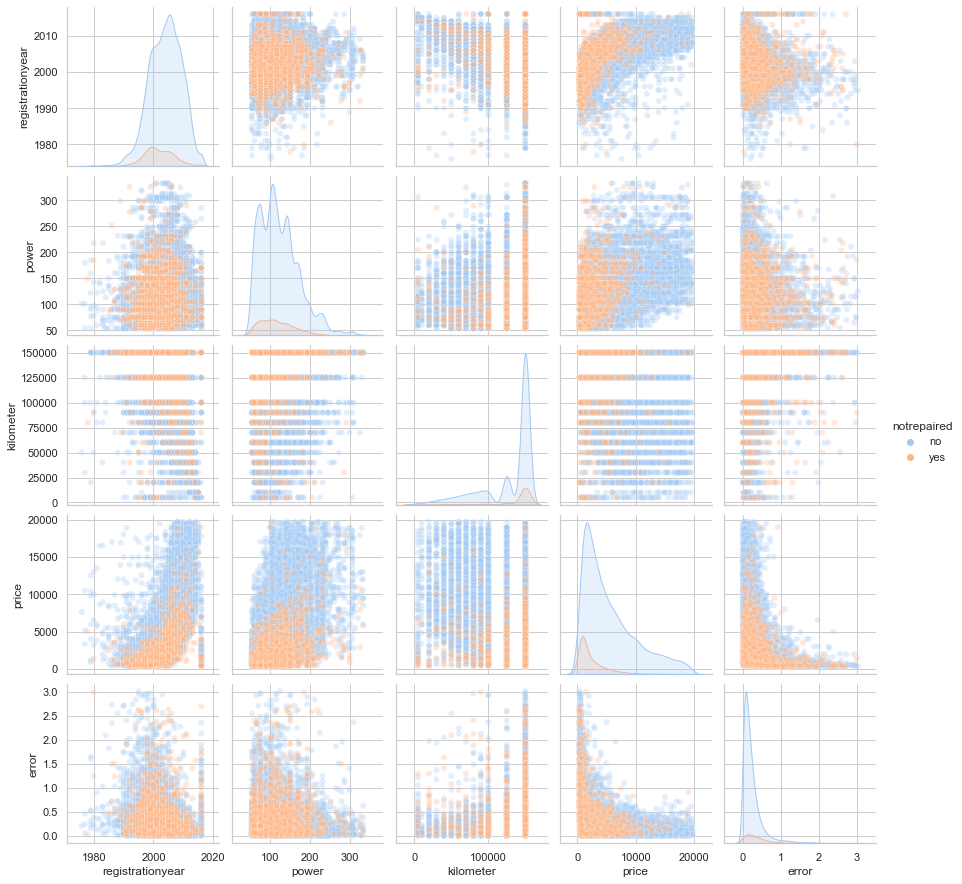

In [121]:
df3 = test_df.copy()
print(len(df3))
for c in df3.columns:
    try:
        q_min = df3[c].quantile(0.005)
        q_max = df3[c].quantile(0.995)
        df3 = df3[df3[c] >= q_min]
        df3 = df3[df3[c] <= q_max]
    except: pass
df3 = df3[df3['model'] != 'other']
df3 = df3[df3['brand'] != 'other']
print(len(df3))
sns.pairplot(
    data=df3.sample(n=15000).sort_values('notrepaired'),
    hue='notrepaired', plot_kws={'alpha':0.3}
);

Само собой, ошибка тем выше, чем ниже "правильная" цена авто. Это и понятно - наши модели оптимизировали MSE, а мы тут смотрим на процентную ошибку. Точно такая же корреляция с мощностью двигателя, но оно и понятно - чем мощнее двигатель, тем дороже авто.

В целом ошибка максимальна для машин с регистрацией около 2000 года, а также для совсем свежих машин 2016 года. Причем свежие машины вообще сильно выбиваются из всех распределений.

Ошибка увеличивается с увеличением километража выше 100к. Это может быть объяснено тем, что там увеличен "шаг", и все значения сваливаются всего в два бина.

Посмотрим еще на нелинейную корреляцию.

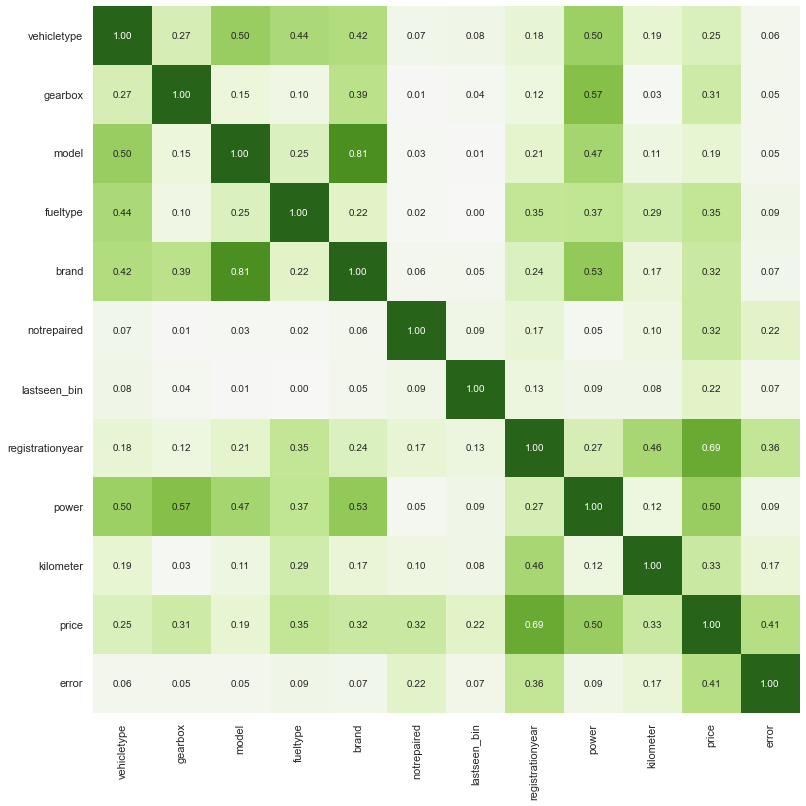

In [122]:
fig = plt.figure(figsize=(13,13))
tmp = df3.copy()
p = preprocessing.OrdinalEncoder()
cat_cols = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired', 'lastseen_bin']
tmp[cat_cols] = p.fit_transform(tmp[cat_cols])

sns.heatmap(data=tmp.phik_matrix(interval_cols=tmp.columns),
    square=True, cmap="PiYG",
    center=0,
    cbar=False,
    annot=True, fmt='.2f', annot_kws={'size': 10});

Видим, что наши категориальные признаки вполне неплохо встроились в модель - ошибка практически не зависит от них.

В то же время ошибка очень сильно коррелирует с ценой, о чем уже сказано выше - это естественно и само по себе не вызывает подозрений, т.к. оптимизировалась метрика MSE.

А еще ошибка сильно коррелирует с годом регистрации, и вот это уже проблема.

На это надо обратить внимание при попытке внедрить нашу модель в рабочий процесс.

## Время расчетов

Подведем небольшой итог по времени.

In [123]:
t = time.time() - project_start
print(f'Время выполнения проекта {t // 3600} час. {(t % 3600) // 60} мин.')

Время выполнения проекта 3.0 час. 46.0 мин.


## Анализ моделей

И опять посмотрим на нашу сводную таблицу, отсортированную по целевой метрике.

In [124]:
result.sort_values('rmse_test')

name  train_time  inference_time    rmse_test   rmse_train  \
2  LGBM_full_lim    6.444438        0.806303  1498.916704   992.289439   
1  LGBM_easy_lim    6.238130        0.539196  1510.748437  1089.115344   
4        cat_lim   12.882939        0.061746  1584.103643  1430.538699   
3   XGB_full_lim   18.293848        0.267106  1597.043701  1417.240234   
5         Neural  467.111735        0.744417  1706.484863  1604.966064   
0         linear    2.974871        0.840189  2660.665996  2624.533065   

   hyper_time  
2      3611.0  
1      1030.0  
4      1806.0  
3      3644.0  
5         NaN  
0      2040.0

Метрики:
- лучшая метрика - у полноценно оптимизированной LGBM модели. Быстро оптимизированная почти не отстает
- линейная модель в данном случае полностью проигрывает. Нейросеть тоже работает плохо
- катбуст и xgb выдают близкие результаты

Время обучения:
- LGBM оправдывает свою репутацию "легкой" модели - обучение самое быстрое (не учитывая линейную регрессию)
- катбуст оправдывает свою репутацю "тяжелой" модели - самое долго обучение из бустингов
- нейронная сеть обучается долго, но для нее не надо искать гиперпараметры (на самом деле желательно, просто я делал это вручную)

Время предсказания:
- все бустинги выдают предсказание на всей обучающей выборке быстрее, чем за секунду, то есть для абсолютного большинства задач они подходят
- как ни странно, LGBM предсказывает медленнее всего, а катбуст - быстрее всего

Отметим, что данные прошли минимальную очистку, поэтому в них осталось большое количество аномалий. Они не были удалены, чтобы приблизить условия работы модели к реальным, то есть можно ожидать, что при применении модели в реальной жизни результат будет не хуже.

В то же время, мы видели, что отклонения предсказанной цены от "настоящей" довольно большие и легко могут достигать 100%+ от стоимости для дешевых машин. То есть работает принцип garbage in, garbage out.

Для внедрения эффективной предсказательной модели рекомендуется ввести sanity check для значений, вводимых пользователями на сайте. Особое внимание следует уделить году регистрации авто.

Кроме того, рекомендуется провести анализ 20-40 наиболее популярных моделей, и для них сделать не ручной ввод информации, а выбор из выпадающих списков. Это позволит получать достоверные данные в среднем более, чем в 50% случаев.